# FLYWIRE CONNECTOME ANALYSIS 

### Imorting all packages/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
from venn import venn
import seaborn as sns; sns.set_theme(style='white')
from matplotlib.colors import LogNorm
import statsmodels.api as sm
from scipy.stats import chi2_contingency

In [2]:
andy_theme = {'axes.grid': True,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': True,
              'legend.fontsize': 14,
              'legend.title_fontsize': 14,
              'font.sans-serif':'Helvetica',
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'axes.labelsize': 12,
              'axes.titlesize': 16,
              'figure.dpi': 100}

plt.rcParams.update(andy_theme)

## FIRST ORDER ANALYSES

### Flywire connections dataset + GRNs identified by Jaeger et al.

In [3]:
connections = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/connections.csv.gz')
sugar_GRNs = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/sugar_GRNs.csv')
water_GRNs = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/water_GRNs.csv')
bitter_GRNs = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/bitter_GRNs.csv')
lowsalt_GRNs = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/lowsalt_GRNs.csv')

### Confirming that all first order neurons are distinct from one anothers

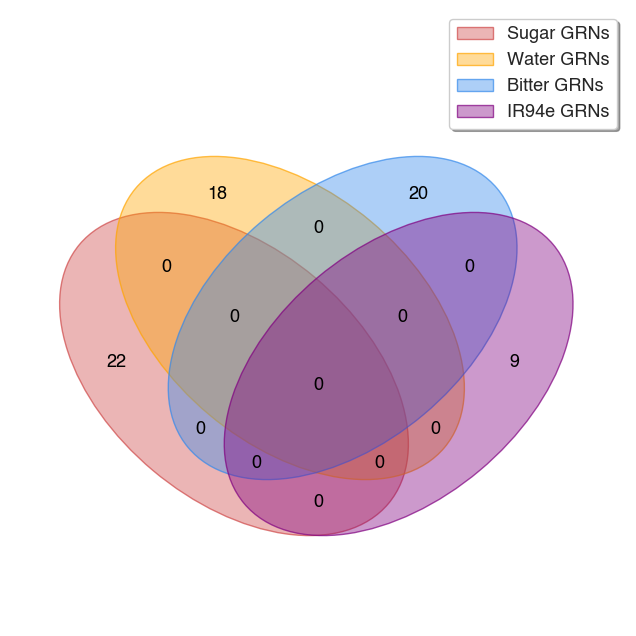

In [4]:
sugar_list = {'{}'.format(value) for value in sugar_GRNs['root_id'].unique()}
sugar_dict = {'Sugar GRNs': sugar_list}

water_list = {'{}'.format(value) for value in water_GRNs['root_id'].unique()}
water_dict = {'Water GRNs': water_list}

bitter_list = {'{}'.format(value) for value in bitter_GRNs['root_id'].unique()}
bitter_dict = {'Bitter GRNs': bitter_list}

lowsalt_list = {'{}'.format(value) for value in lowsalt_GRNs['root_id'].unique()}
lowsalt_dict = {'IR94e GRNs': lowsalt_list}

colors = ('#cf4848','orange','#3489eb','purple')
crossover = {**sugar_dict, **water_dict, **bitter_dict, **lowsalt_dict}
venn(crossover, cmap = ListedColormap(colors))
plt.show()

### Looking at axonal outputs of first order neurons
- neuron downstream of taste GRN
- minimum of 5 synapses between the two neurons (synonomous list with second orders, formula is mostly defined for later use)

In [5]:
def neuronal_outputs(taste_neurons):
        connectivity = pd.merge(taste_neurons['root_id'], connections[['pre_root_id','post_root_id','neuropil','syn_count','nt_type']], \
                left_on = 'root_id', right_on = 'pre_root_id', how = 'inner').query("syn_count >= 5")
        connectivity = connectivity.drop(columns = 'root_id')
        def projection(neuropil):
                if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R','CAN']:
                        return 'local'
                else: 
                        return 'outside_SEZ'
        connectivity['location_of_connection'] = connectivity['neuropil'].apply(projection)
        return connectivity

In [6]:
sugarGRN_outputs = neuronal_outputs(sugar_GRNs)
waterGRN_outputs = neuronal_outputs(water_GRNs)
bitterGRN_outputs = neuronal_outputs(bitter_GRNs)
lowsaltGRN_outputs = neuronal_outputs(lowsalt_GRNs)

### Quanifying GRN to GRN communication

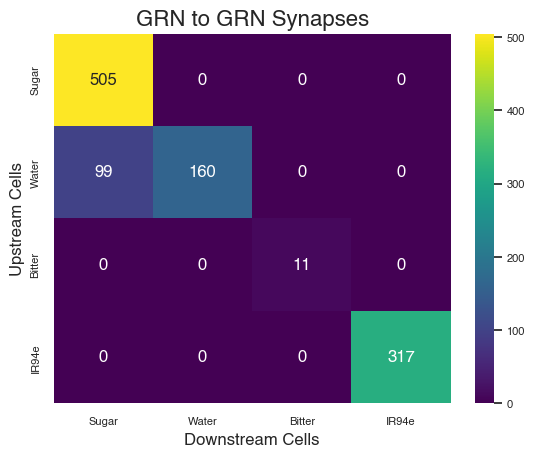

In [7]:
def heatmap(tasteGRN_outputs):
    df = [sugar_GRNs, water_GRNs, bitter_GRNs, lowsalt_GRNs]
    taste_connectivity = []
    array = []
    for i in range(len(df)): 
        taste_connectivity.append(pd.merge(tasteGRN_outputs, df[i], left_on = 'post_root_id', right_on = 'root_id', how = 'inner'))
        array.append(taste_connectivity[i]['syn_count'].sum())
    return array

heatmap_GRNs = [heatmap(sugarGRN_outputs), heatmap(waterGRN_outputs), heatmap(bitterGRN_outputs), heatmap(lowsaltGRN_outputs)]
row_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
col_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
sns.heatmap(heatmap_GRNs, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels)  # 'fmt="d"' to display integer values
plt.title("GRN to GRN Synapses")
plt.ylabel("Upstream Cells")
plt.xlabel("Downstream Cells")
plt.show()

## SECOND ORDER ANALYSES

### Defining a formula to identify second order neurons
- neuron downstream of taste GRN
- minimum of 5 synapses between the two neurons

In [8]:
def second_order(taste_GRNs, taste):
        connectivity = pd.merge(taste_GRNs['root_id'], connections[['pre_root_id','post_root_id','neuropil','syn_count','nt_type']], left_on = 'root_id', right_on = 'pre_root_id', how = 'inner').query("syn_count >= 5")
        connectivity = connectivity.drop(columns = 'root_id')
        second_orders = connectivity.groupby("post_root_id").agg({'pre_root_id' : 'nunique', 'syn_count' : 'sum'}).reset_index()
        second_orders.columns = ['root_id','upstream_' + taste + '_GRNs', taste + '_syn_count']
        second_orders['const'] = 1
        return connectivity, second_orders

In [9]:
sugar_second_order_connectivity, sugar_2Ns = second_order(sugar_GRNs, 'sugar')
water_second_order_connectivity, water_2Ns = second_order(water_GRNs, 'water')
bitter_second_order_connectivity, bitter_2Ns = second_order(bitter_GRNs, 'bitter')
lowsalt_second_order_connectivity, lowsalt_2Ns = second_order(lowsalt_GRNs, 'lowsalt')

### Importing more information about 2Ns from flywire

In [10]:
sugar2N_data = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/sugar2Ns_data.csv')[['root_id','label','nt_type','side','input_synapses','output_synapses']]
water2N_data = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/water2Ns_data.csv')[['root_id','label','nt_type','side','input_synapses','output_synapses']]
bitter2N_data = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/bitter2Ns_data.csv')[['root_id','label','nt_type','side','input_synapses','output_synapses']]
lowsalt2N_data = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/lowsalt2Ns_data.csv')[['root_id','label','nt_type','side','input_synapses','output_synapses']]

In [11]:
sugar_2Ns = pd.merge(sugar_2Ns, sugar2N_data, on = 'root_id', how = 'outer')
water_2Ns = pd.merge(water_2Ns, water2N_data, on = 'root_id', how = 'outer')
bitter_2Ns = pd.merge(bitter_2Ns, bitter2N_data, on = 'root_id', how = 'outer')
lowsalt_2Ns = pd.merge(lowsalt_2Ns, lowsalt2N_data, on = 'root_id', how = 'outer')

### Venn diagram to visualize crossover within second order neurons

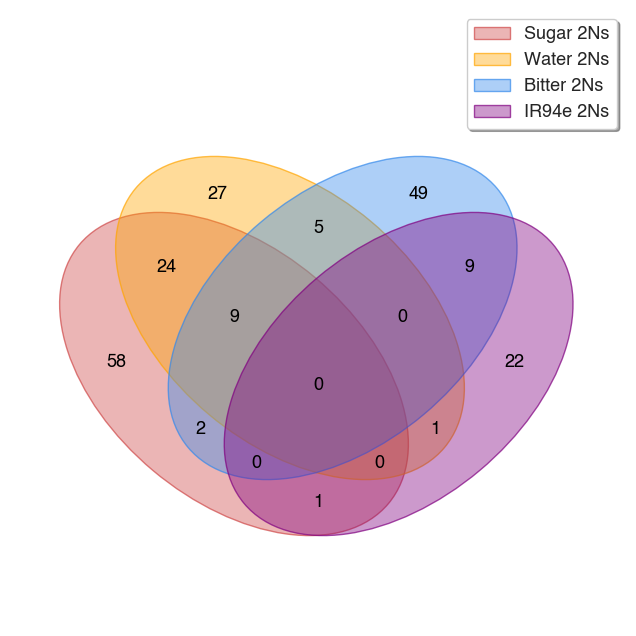

In [12]:
sugar_list = {'{}'.format(value) for value in sugar_2Ns['root_id'].unique()}
sugar_dict = {'Sugar 2Ns': sugar_list}

water_list = {'{}'.format(value) for value in water_2Ns['root_id'].unique()}
water_dict = {'Water 2Ns': water_list}

bitter_list = {'{}'.format(value) for value in bitter_2Ns['root_id'].unique()}
bitter_dict = {'Bitter 2Ns': bitter_list}

lowsalt_list = {'{}'.format(value) for value in lowsalt_2Ns['root_id'].unique()}
lowsalt_dict = {'IR94e 2Ns': lowsalt_list}

colors = ('#cf4848','orange','#3489eb','purple')
crossover = {**sugar_dict, **water_dict, **bitter_dict, **lowsalt_dict}
venn(crossover, cmap = ListedColormap(colors))
plt.show()

### Looking at unthresholded axonal outputs of second order neurons
- neuron downstream of second order neuron 
- minimum of 5 synapses with second orders
- not filtering out "third orders" that are also GRNs, second orders

In [13]:
sugar2N_outputs = neuronal_outputs(sugar_2Ns)
water2N_outputs = neuronal_outputs(water_2Ns)
bitter2N_outputs = neuronal_outputs(bitter_2Ns)
lowsalt2N_outputs = neuronal_outputs(lowsalt_2Ns)

### Quanitifying 2N to 2N communication

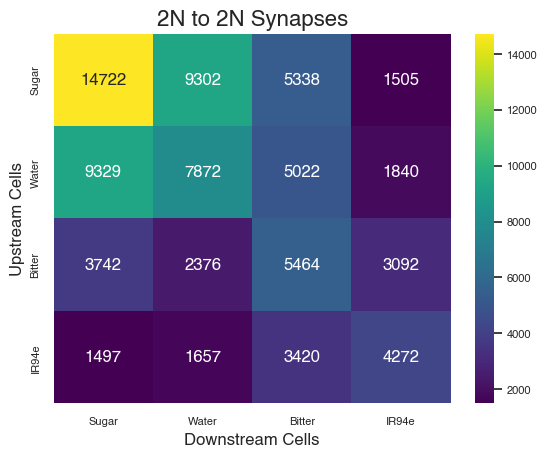

In [14]:
def heatmap(taste2N_outputs):
    df = [sugar_2Ns, water_2Ns, bitter_2Ns, lowsalt_2Ns]
    taste_connectivity = []
    array = []
    for i in range(len(df)): 
        taste_connectivity.append(pd.merge(taste2N_outputs, df[i], left_on = 'post_root_id', right_on = 'root_id', how = 'inner'))
        array.append(taste_connectivity[i]['syn_count'].sum())
    return array

heatmap_2Ns = [heatmap(sugar2N_outputs),heatmap(water2N_outputs), heatmap(bitter2N_outputs), heatmap(lowsalt2N_outputs)]
row_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
col_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
sns.heatmap(heatmap_2Ns, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels) 
plt.title("2N to 2N Synapses")
plt.ylabel("Upstream Cells")
plt.xlabel("Downstream Cells")
plt.show()

### Excitatory 2N to 2N communication

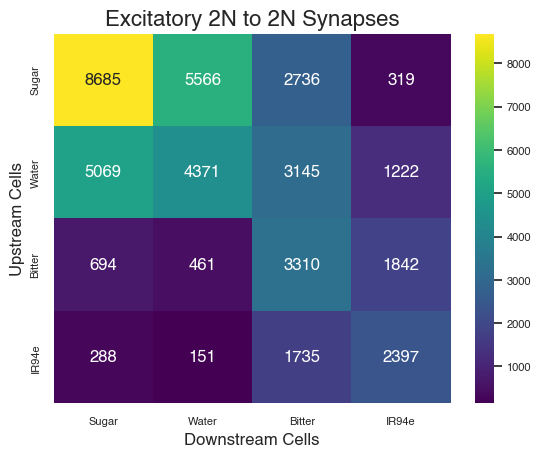

In [15]:
heatmap_2Ns = [heatmap(sugar2N_outputs.query("nt_type == 'ACH'")),heatmap(water2N_outputs.query("nt_type == 'ACH'")), \
               heatmap(bitter2N_outputs.query("nt_type == 'ACH'")), heatmap(lowsalt2N_outputs.query("nt_type == 'ACH'"))]
row_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
col_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
sns.heatmap(heatmap_2Ns, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels)  
plt.title("Excitatory 2N to 2N Synapses")
plt.ylabel("Upstream Cells")
plt.xlabel("Downstream Cells")
plt.show()

### Inhibitory 2N to 2N communication

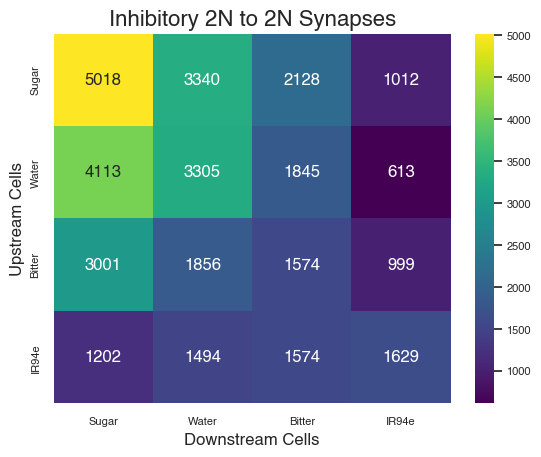

In [16]:
heatmap_2Ns = [heatmap(sugar2N_outputs.query("nt_type.isin(['GABA','GLUT'])")),heatmap(water2N_outputs.query("nt_type.isin(['GABA','GLUT'])")), \
               heatmap(bitter2N_outputs.query("nt_type.isin(['GABA','GLUT'])")), heatmap(lowsalt2N_outputs.query("nt_type.isin(['GABA','GLUT'])"))]
row_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
col_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
sns.heatmap(heatmap_2Ns, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels) 
plt.title("Inhibitory 2N to 2N Synapses")
plt.ylabel("Upstream Cells")
plt.xlabel("Downstream Cells")
plt.show()

### 2N to GRN communication

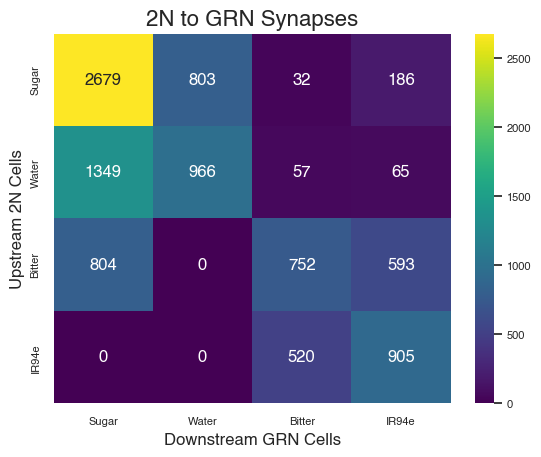

In [17]:
def heatmap(taste2N_outputs):
    df = [sugar_GRNs, water_GRNs, bitter_GRNs, lowsalt_GRNs]
    taste_connectivity = []
    array = []
    for i in range(len(df)): 
        taste_connectivity.append(pd.merge(taste2N_outputs, df[i], left_on = 'post_root_id', right_on = 'root_id', how = 'inner'))
        array.append(taste_connectivity[i]['syn_count'].sum())
    return array

heatmap_2Ns = [heatmap(sugar2N_outputs),heatmap(water2N_outputs), heatmap(bitter2N_outputs), heatmap(lowsalt2N_outputs)]
row_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
col_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
sns.heatmap(heatmap_2Ns, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels) 
plt.title("2N to GRN Synapses")
plt.ylabel("Upstream 2N Cells")
plt.xlabel("Downstream GRN Cells")
plt.show()

### Heatmap to see the overlap in connectivity between modalities for GRN --> 2Ns

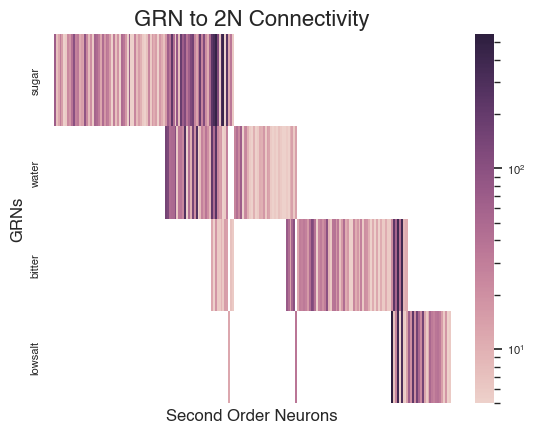

In [18]:
heatmap_data = pd.concat([sugar_second_order_connectivity, water_second_order_connectivity, bitter_second_order_connectivity, lowsalt_second_order_connectivity], axis = 0)

heatmap_data['post_root_id_group'] = ' '
for entry in heatmap_data['post_root_id']:
    heatmap_data.loc[heatmap_data['post_root_id'] == entry, 'post_root_id_group'] = ' '
    group = ''
    if entry in sugar_2Ns['root_id'].values:
        group += 'sugar'
    if entry in water_2Ns['root_id'].values:
        group += 'water'
    if entry in bitter_2Ns['root_id'].values:
        group += 'bitter'
    if entry in lowsalt_2Ns['root_id'].values:
        group += 'lowsalt'
    if group:
        heatmap_data.loc[heatmap_data['post_root_id'] == entry, 'post_root_id_group'] = group

for entry in heatmap_data['pre_root_id']:
    if entry in sugar_GRNs['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'sugar'
    elif entry in water_GRNs['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'water'
    elif entry in bitter_GRNs['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'bitter'
    elif entry in lowsalt_GRNs['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'lowsalt'
    else:
        pass
    
custom_order_2Ns = heatmap_data['post_root_id_group'].unique() 
custom_order_GRNs = heatmap_data['pre_root_id_group'].unique() 
heatmap_data['post_root_id_group'] = pd.Categorical(heatmap_data['post_root_id_group'], categories=custom_order_2Ns, ordered=True)
heatmap_data['pre_root_id_group'] = pd.Categorical(heatmap_data['pre_root_id_group'], categories=custom_order_GRNs, ordered=True)
df_sorted = heatmap_data.sort_values(by='post_root_id_group')

heatmap_matrix = df_sorted.pivot_table(index = 'pre_root_id_group', columns = 'post_root_id', values = 'syn_count', aggfunc='sum', fill_value = 0)
desired_column_order = df_sorted['post_root_id'].unique()
heatmap_matrix = heatmap_matrix[desired_column_order]

sns.heatmap(heatmap_matrix, norm=LogNorm(),cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=False)
plt.title('GRN to 2N Connectivity')
plt.xlabel('Second Order Neurons')
plt.ylabel('GRNs')
plt.show()

### Adding a column for % input coming from GRNs + average upstream synapses


In [19]:
sugar_2Ns['%_sugar_input'] = sugar_2Ns['sugar_syn_count']/sugar_2Ns['input_synapses']*100
water_2Ns['%_water_input'] = water_2Ns['water_syn_count']/water_2Ns['input_synapses']*100
bitter_2Ns['%_bitter_input'] = bitter_2Ns['bitter_syn_count']/bitter_2Ns['input_synapses']*100
lowsalt_2Ns['%_lowsalt_input'] = lowsalt_2Ns['lowsalt_syn_count']/lowsalt_2Ns['input_synapses']*100

In [20]:
sugar_2Ns['avg_upstream_synapses'] = sugar_2Ns['sugar_syn_count']/sugar_2Ns['upstream_sugar_GRNs']
water_2Ns['avg_upstream_synapses'] = water_2Ns['water_syn_count']/water_2Ns['upstream_water_GRNs']
bitter_2Ns['avg_upstream_synapses'] = bitter_2Ns['bitter_syn_count']/bitter_2Ns['upstream_bitter_GRNs']
lowsalt_2Ns['avg_upstream_synapses'] = lowsalt_2Ns['lowsalt_syn_count']/lowsalt_2Ns['upstream_lowsalt_GRNs']

### Visualizing the proportion of input 2Ns receive (# synapses vs # cells) + OLS modeling to see if there's a significant relationship between our variables

In [21]:
def synapse_scatter_2Ns(taste_2Ns, taste, color, title):
    x = taste_2Ns['upstream_' + taste + '_GRNs'].astype('int')
    y = taste_2Ns['avg_upstream_synapses']
    def objective(x, a, b):
        return a * x + b
    popt, _ = curve_fit(objective, x, y)
    a, b = popt
    fig, ax = plt.subplots()
    sns.stripplot(data=taste_2Ns, x='upstream_' + taste + '_GRNs', y="avg_upstream_synapses", color = color)
    x_line = np.arange(0, max(x), 1)
    y_line = objective(x_line, a, b)
    ax.plot(x_line, y_line, '--', color='black')
    ax.set_xticks(np.arange(0, max(x) + 1, step=1))
    ax.set_yticks(np.arange(0, max(y) + 1, step=2))
    ax.set_xlabel('# Upsteam GRNs')
    ax.set_ylabel('Average # of Input Synapses')
    ax.set_title('Convergence Within ' + title + ' 2Ns')
    plt.show()
    formula = ('y = %.5f * x + %.5f' % (a, b))
    return formula

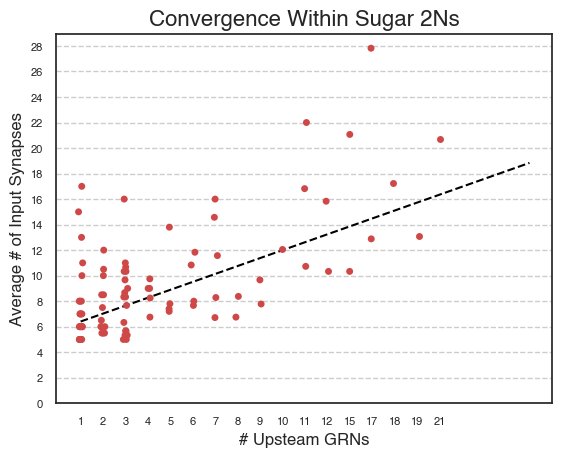

'y = 0.62149 * x + 6.40534'

In [22]:
synapse_scatter_2Ns(sugar_2Ns, 'sugar', '#cf4848', 'Sugar')

In [23]:
sugar_model = sm.OLS(sugar_2Ns['avg_upstream_synapses'], sugar_2Ns[['const','upstream_sugar_GRNs']]).fit()
sugar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.448
Model:                               OLS   Adj. R-squared:                  0.442
Method:                    Least Squares   F-statistic:                     74.67
Date:                   Fri, 17 May 2024   Prob (F-statistic):           1.65e-13
Time:                           14:27:08   Log-Likelihood:                -243.10
No. Observations:                     94   AIC:                             490.2
Df Residuals:                         92   BIC:                             495.3
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.4053      0.470     13.642      0.000       5.473       7.338
upstream_sugar_GRNs     0.6215      0.072      8.641      0.000       0.479       0.764
==============================================================================
Omnibus:                       24.116   Durbin-Watson:                   1.544
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.182
Skew:                           1.224   Prob(JB):                     6.23e-08
Kurtosis:                       4.574   Cond. No.                         9.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

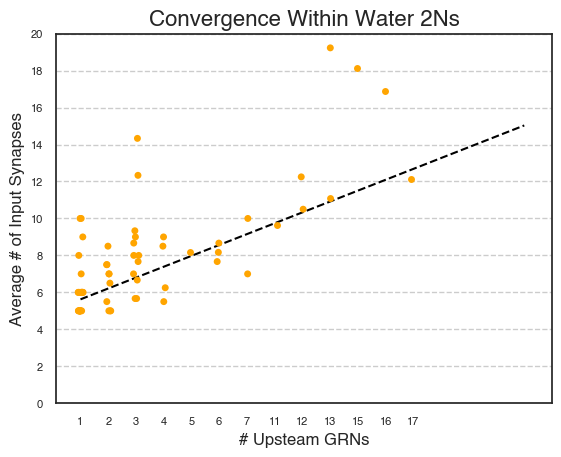

'y = 0.58816 * x + 5.62262'

In [24]:
synapse_scatter_2Ns(water_2Ns, 'water', 'orange','Water')

In [25]:
water_model = sm.OLS(water_2Ns['avg_upstream_synapses'], water_2Ns[['const','upstream_water_GRNs']]).fit()
water_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.588
Model:                               OLS   Adj. R-squared:                  0.582
Method:                    Least Squares   F-statistic:                     91.37
Date:                   Fri, 17 May 2024   Prob (F-statistic):           6.05e-14
Time:                           14:27:09   Log-Likelihood:                -139.23
No. Observations:                     66   AIC:                             282.5
Df Residuals:                         64   BIC:                             286.8
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.6226      0.338     16.659      0.000       4.948       6.297
upstream_water_GRNs     0.5882      0.062      9.559      0.000       0.465       0.711
==============================================================================
Omnibus:                       22.512   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.141
Skew:                           1.352   Prob(JB):                     1.05e-07
Kurtosis:                       5.092   Cond. No.                         7.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

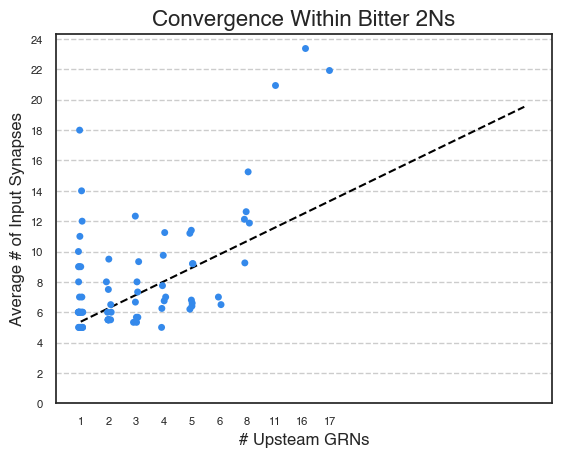

'y = 0.88514 * x + 5.37610'

In [26]:
synapse_scatter_2Ns(bitter_2Ns, 'bitter', '#3489eb','Bitter')

In [27]:
bitter_model = sm.OLS(bitter_2Ns['avg_upstream_synapses'], bitter_2Ns[['const','upstream_bitter_GRNs']]).fit()
bitter_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.501
Model:                               OLS   Adj. R-squared:                  0.494
Method:                    Least Squares   F-statistic:                     72.31
Date:                   Fri, 17 May 2024   Prob (F-statistic):           1.76e-12
Time:                           14:27:09   Log-Likelihood:                -180.46
No. Observations:                     74   AIC:                             364.9
Df Residuals:                         72   BIC:                             369.5
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.3761      0.473     11.370      0.000       4.434       6.319
upstream_bitter_GRNs     0.8851      0.104      8.504      0.000       0.678       1.093
==============================================================================
Omnibus:                       31.705   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.533
Skew:                           1.514   Prob(JB):                     9.70e-15
Kurtosis:                       6.430   Cond. No.                         6.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

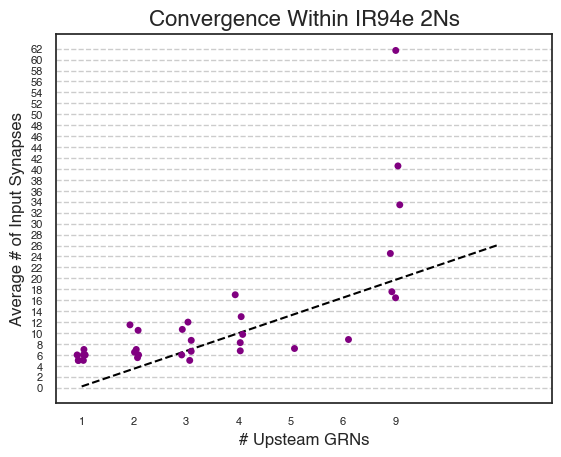

'y = 3.24641 * x + 0.23831'

In [28]:
synapse_scatter_2Ns(lowsalt_2Ns, 'lowsalt', 'purple','IR94e')

In [29]:
lowsalt_model = sm.OLS(lowsalt_2Ns['avg_upstream_synapses'], lowsalt_2Ns[['const','upstream_lowsalt_GRNs']]).fit()
lowsalt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.579
Model:                               OLS   Adj. R-squared:                  0.566
Method:                    Least Squares   F-statistic:                     42.72
Date:                   Fri, 17 May 2024   Prob (F-statistic):           2.70e-07
Time:                           14:27:11   Log-Likelihood:                -114.10
No. Observations:                     33   AIC:                             232.2
Df Residuals:                         31   BIC:                             235.2
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2383      2.309      0.103      0.918      -4.471       4.947
upstream_lowsalt_GRNs     3.2464      0.497      6.536      0.000       2.233       4.259
==============================================================================
Omnibus:                       30.501   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.383
Skew:                           1.906   Prob(JB):                     2.36e-20
Kurtosis:                      10.156   Cond. No.                         8.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Looking at the synapse distribution for each modality

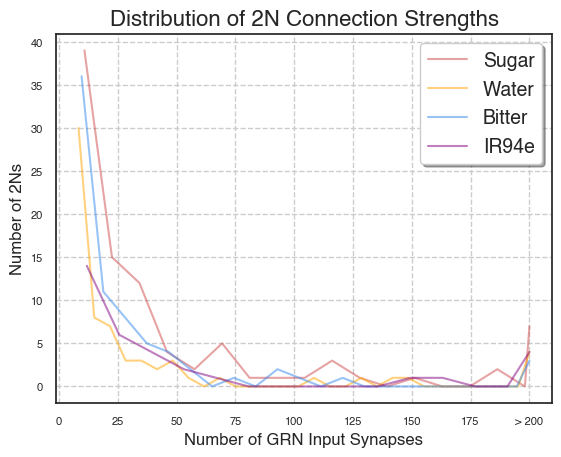

In [30]:
def synapse_distribution_2Ns(taste_2Ns, taste):
    data = taste_2Ns[taste + '_syn_count']
    num_bins = 40 
    bins = np.linspace(min(data), max(data), num_bins + 1)
    frequencies, bin_edges = np.histogram(data, bins)
    bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
    df = pd.DataFrame({'labels': bin_labels, 'frequencies' : frequencies})
    df = df.sort_values(by = 'labels', ascending= True)
    def custom_label(label):
        if label > 200:
            return '200'
        else:
            return label
    df['label_category'] = df['labels'].apply(custom_label)
    df = df.groupby('label_category', as_index=False)['frequencies'].sum()
    return df

sugar_synapse_distribution = synapse_distribution_2Ns(sugar_2Ns, 'sugar')
water_synapse_distribution = synapse_distribution_2Ns(water_2Ns, 'water')
bitter_synapse_distribution = synapse_distribution_2Ns(bitter_2Ns, 'bitter')
lowsalt_synapse_distribution = synapse_distribution_2Ns(lowsalt_2Ns, 'lowsalt')

dataframes = [sugar_synapse_distribution, water_synapse_distribution, bitter_synapse_distribution, lowsalt_synapse_distribution]
labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
colors = ['#cf4848', 'orange', '#3489eb', 'purple']

for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['label_category'], df['frequencies'], label=label, alpha=0.5, color=color)

xlabels = np.array(np.arange(0,201, 25), dtype= str)
xlabels[-1] = '> 200'
plt.xticks(ticks = 25 * np.arange(len(xlabels)) , labels = xlabels)
plt.xlabel('Number of GRN Input Synapses')
plt.ylabel('Number of 2Ns')
plt.title('Distribution of 2N Connection Strengths')
plt.legend()
plt.show()

### Defining second order neurons as local vs projection (synapse only in the SEZ vs other brain region)

In [31]:
def classify_2Ns(taste_2Ns):
    second_orders = pd.merge(taste_2Ns['root_id'], connections[['pre_root_id','post_root_id','neuropil','syn_count','nt_type']], \
                    left_on = 'root_id', right_on = 'pre_root_id', how = 'inner').query("syn_count >= 5")
    def projection(neuropil):
        if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R','CAN']:
            return 'local'
        else: 
            return 'outside_SEZ'
    second_orders['location_of_connection'] = second_orders['neuropil'].apply(projection)
    classifications = [] 
    for entry in second_orders['pre_root_id'].unique():
        if entry in second_orders.query("location_of_connection != 'local'")['pre_root_id'].unique():
            classification = pd.DataFrame({'root_id': [entry], 'neuron_type': 'projection',
                                        '#_projection_synapses': second_orders.query(
                                                f"pre_root_id == {entry} & location_of_connection != 'local'")[
                                                'syn_count'].sum()}, index=[0]) 
            classifications.append(classification)
        else:
            classification = pd.DataFrame({'root_id': [entry], 'neuron_type': 'local',
                                        '#_projection_synapses': second_orders.query(
                                            f"pre_root_id == {entry} & location_of_connection != 'local'")[
                                            'syn_count'].sum()}, index=[0]) 
            classifications.append(classification)

    result = pd.concat(classifications, ignore_index=True) 
    return result

In [32]:
sugar_2Ns = pd.merge(sugar_2Ns, classify_2Ns(sugar_2Ns), on = 'root_id')
water_2Ns = pd.merge(water_2Ns, classify_2Ns(water_2Ns), on = 'root_id')
bitter_2Ns = pd.merge(bitter_2Ns, classify_2Ns(bitter_2Ns), on = 'root_id')
lowsalt_2Ns = pd.merge(lowsalt_2Ns, classify_2Ns(lowsalt_2Ns), on = 'root_id')

### Comparing local vs projection second order neurons across modalities

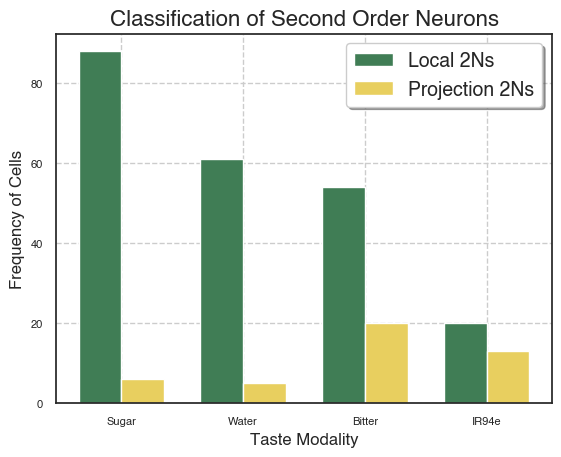

In [33]:
categories = ['Sugar','Water','Bitter','IR94e']
datasets = [sugar_2Ns, water_2Ns, bitter_2Ns, lowsalt_2Ns]

local_neurons = []
projection_neurons = []

for dataset in datasets:
    local_neurons.append(len(dataset.query("neuron_type == 'local'")))
    projection_neurons.append(len(dataset.query("neuron_type == 'projection'")))
    chi_2N_neurons = [local_neurons, projection_neurons]

x = range(len(categories))
bar_width = 0.35

plt.bar(x, local_neurons, width=bar_width,label = "Local 2Ns", color = '#407d55')
plt.bar([i+ bar_width for i in x], projection_neurons, width=bar_width, label = "Projection 2Ns", color = '#e8cf5f')

plt.xlabel('Taste Modality')
plt.ylabel('Frequency of Cells')
plt.title('Classification of Second Order Neurons')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend()
plt.show()

In [34]:
stat, p, dof, expected = chi2_contingency(chi_2N_neurons)

alpha = 0.05
print("p value is " + str(p) )
if p <= alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

p value is 1.905166204375466e-06
Reject H0


### Comparing local vs projection second order synapses across modalities

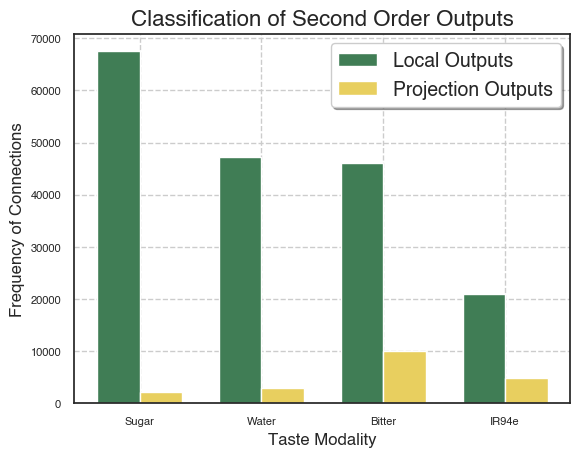

In [35]:
categories = ['Sugar','Water','Bitter','IR94e']
datasets = [sugar2N_outputs, water2N_outputs, bitter2N_outputs, lowsalt2N_outputs]

local_synapses = []
projection_synapses = []

for dataset in datasets:
    local_synapses.append(dataset.query("location_of_connection == 'local'")['syn_count'].sum())
    projection_synapses.append(dataset.query("location_of_connection == 'outside_SEZ'")['syn_count'].sum())
    chi_2N_synapses = [local_synapses, projection_synapses]
    
x = range(len(categories))

bar_width = 0.35

plt.bar(x, local_synapses, width=bar_width,label = "Local Outputs", color = '#407d55')
plt.bar([i+ bar_width for i in x], projection_synapses, width=bar_width, label = "Projection Outputs", color = '#e8cf5f')

plt.xlabel('Taste Modality')
plt.ylabel('Frequency of Connections')
plt.title('Classification of Second Order Outputs')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend()
plt.show()

In [36]:
stat, p, dof, expected = chi2_contingency(chi_2N_synapses)

alpha = 0.05
print("p value is " + str(p) )
if p <= alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

p value is 0.0
Reject H0


### NT distribution for local + projection 2N outputs across modalities

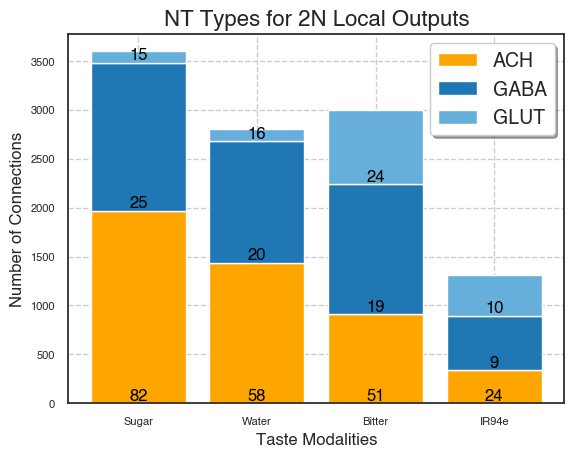

In [37]:
NTs = ['ACH','GABA','GLUT']
categories = ['Sugar','Water','Bitter','IR94e']

datasets = [sugar2N_outputs, water2N_outputs, bitter2N_outputs, lowsalt2N_outputs]
def count_NTs(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(len(dataset.query("location_of_connection == 'local' and nt_type == @NTs[0]")))
        ACH_connections = np.array(variable1)
        variable2.append(len(dataset.query("location_of_connection == 'local' and nt_type == @NTs[1]")))
        GABA_connections = np.array(variable2)
        variable3.append(len(dataset.query("location_of_connection == 'local' and nt_type == @NTs[2]")))
        GLUT_connections = np.array(variable3)
    return ACH_connections,GABA_connections,GLUT_connections

def count_neurons(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(dataset.query("location_of_connection == 'local' and nt_type == @NTs[0]")['pre_root_id'].nunique())
        ACH_neurons = np.array(variable1)
        variable2.append(dataset.query("location_of_connection == 'local' and nt_type == @NTs[1]")['pre_root_id'].nunique())
        GABA_neurons = np.array(variable2)
        variable3.append(dataset.query("location_of_connection == 'local' and nt_type == @NTs[2]")['pre_root_id'].nunique())
        GLUT_neurons = np.array(variable3)
    return ACH_neurons,GABA_neurons,GLUT_neurons

variables = count_NTs(datasets, categories)
neurons = count_neurons(datasets, categories)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(1,5)
bar_width = 0.8
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, variables[0], width=bar_width,color = 'orange')
ax2 = ax.bar(bar_l, variables[1], bottom = variables[0], width=bar_width,color = '#1f77b4')
ax3= ax.bar(bar_l, variables[2], bottom= variables[0]+variables[1], width=bar_width,color = '#67afdb')
ax.set_ylabel('Number of Connections')
ax.set_xlabel('Taste Modalities')
ax.legend(NTs)
ax.set_title('NT Types for 2N Local Outputs')
plt.xticks(tick_pos, categories)

for r1, r2, r3, n1, n2, n3 in zip(ax1, ax2, ax3, neurons[0], neurons[1], neurons[2]):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., 0, n1, ha="center", va="bottom", color="black", fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1, n2, ha="center", va="bottom", color="black",  fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 , n3, ha="center", va="bottom", color="black",  fontweight="bold")


plt.show()

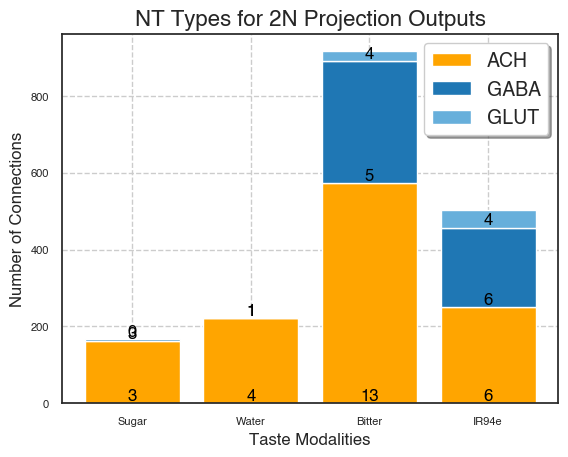

In [38]:
NTs = ['ACH','GABA','GLUT']
categories = ['Sugar','Water','Bitter','IR94e']

datasets = [sugar2N_outputs, water2N_outputs, bitter2N_outputs, lowsalt2N_outputs]
def count_NTs(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(len(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[0]")))
        ACH_connections = np.array(variable1)
        variable2.append(len(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[1]")))
        GABA_connections = np.array(variable2)
        variable3.append(len(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[2]")))
        GLUT_connections = np.array(variable3)
    return ACH_connections,GABA_connections,GLUT_connections

def count_neurons(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[0]")['pre_root_id'].nunique())
        ACH_neurons = np.array(variable1)
        variable2.append(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[1]")['pre_root_id'].nunique())
        GABA_neurons = np.array(variable2)
        variable3.append(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[2]")['pre_root_id'].nunique())
        GLUT_neurons = np.array(variable3)
    return ACH_neurons,GABA_neurons,GLUT_neurons

variables = count_NTs(datasets, categories)
neurons = count_neurons(datasets, categories)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(1,5)
bar_width = 0.8
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, variables[0], width=bar_width,color = 'orange')
ax2 = ax.bar(bar_l, variables[1], bottom = variables[0], width=bar_width,color = '#1f77b4')
ax3= ax.bar(bar_l, variables[2], bottom= variables[0]+variables[1], width=bar_width,color = '#67afdb')
ax.set_ylabel('Number of Connections')
ax.set_xlabel('Taste Modalities')
ax.legend(NTs)
ax.set_title('NT Types for 2N Projection Outputs')
plt.xticks(tick_pos, categories)

for r1, r2, r3, n1, n2, n3 in zip(ax1, ax2, ax3, neurons[0], neurons[1], neurons[2]):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., 0, n1, ha="center", va="bottom", color="black", fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1, n2, ha="center", va="bottom", color="black",  fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 , n3, ha="center", va="bottom", color="black",  fontweight="bold")


plt.show()

### Mapping out ipsilateral vs contralateral 2N outputs across modalities

In [39]:
def bilateral(neuropil):
    if neuropil.endswith('_L'):
        return 'ipsilateral'
    elif neuropil.endswith('_R'):
        return 'contralateral'
    else:
        return 'central'

In [40]:
sugar2N_outputs['hemisphere'] = sugar2N_outputs['neuropil'].apply(bilateral)
water2N_outputs['hemisphere'] = water2N_outputs['neuropil'].apply(bilateral)
bitter2N_outputs['hemisphere'] = bitter2N_outputs['neuropil'].apply(bilateral)
lowsalt2N_outputs['hemisphere'] = lowsalt2N_outputs['neuropil'].apply(bilateral)

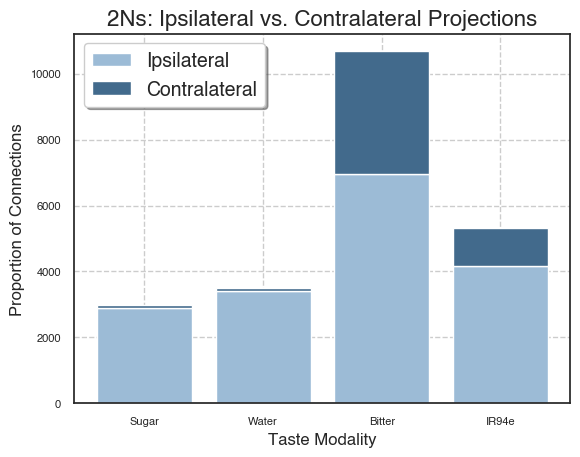

In [41]:
second_order_outputs = [sugar2N_outputs, water2N_outputs, bitter2N_outputs, lowsalt2N_outputs]

ipsilateral = []
contralateral = []

for entry in second_order_outputs:
    ipsilateral.append(entry.query("hemisphere == 'ipsilateral'")['syn_count'].sum())
    contralateral.append(entry.query("hemisphere == 'contralateral'")['syn_count'].sum())

categories = ['Sugar', 'Water', 'Bitter', 'IR94e']
brain_hemisphere = ['Ipsilateral', 'Contralateral']

plt.bar(categories, ipsilateral, color = '#9cbbd6')
plt.bar(categories, contralateral, bottom = ipsilateral, color = '#426a8c')
plt.title('2Ns: Ipsilateral vs. Contralateral Projections')
plt.ylabel('Proportion of Connections')
plt.xlabel('Taste Modality')
plt.legend(brain_hemisphere)
plt.show()

### Consolidating bilateral brain regions for second order outputs

In [42]:
region_mapping = {
    'AL_L' :'AL', 'AL_R' : 'AL',
    'AOTU_L' : 'AOTU', 'AOTU_R' : 'AOTU',
    'AVLP_L' : 'AVLP','AVLP_R' : 'AVLP',
    'CRE_L' : 'CRE', 'CRE_R' : 'CRE',
    'FLA_L' : 'FLA', 'FLA_R' : 'FLA',
    'GOR_L' : 'GOR', 'GOR_R': 'GOR',
    'IB_L' : 'IB', 'IB_R' : 'IB',
    'ICL_L' : 'ICL','ICL_R' : 'ICL',
    'IPS_L' : 'IPS','IPS_R' : 'IPS',
    'LAL_L' : 'LAL','LAL_R' : 'LAL',
    'LH_L' : 'LH','LH_R' : 'LH',
    'MB_CA_L' :'MB_CA', 'MB_CA_R' : 'MB_CA',
    'MB_PED_L' :'MB_PED', 'MB_PED_R' : 'MB_PED',
    'MB_VL_L' : 'MB_VL', 'MB_VL_R' : 'MB_VL',
    'PLP_L' : 'PLP','PLP_R' : 'PLP',
    'PVLP_L' : 'PVLP','PVLP_R' : 'PVLP',
    'SCL_L' : 'SCL','SCL_R' : 'SCL',
    'SIP_L' : 'SIP', 'SIP_R' : 'SIP',
    'SCP_L': 'SCP','SCP_R': 'SCP',
    'SLP_L': 'SLP','SLP_R': 'SLP',
    'SMP_L': 'SMP','SMP_R': 'SMP',
    'SPS_L' : 'SPS', 'SPS_R' : 'SPS',
    'VES_L' : 'VES','VES_R' : 'VES',
    'WED_L' : 'WED', 'WED_R' : 'WED'
}

In [43]:
sugar2N_outputs['neuropil_remap'] = sugar2N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
water2N_outputs['neuropil_remap'] = water2N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
bitter2N_outputs['neuropil_remap'] = bitter2N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
lowsalt2N_outputs['neuropil_remap'] = lowsalt2N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))

### Bar graph of brain regions that each modality is projecting to

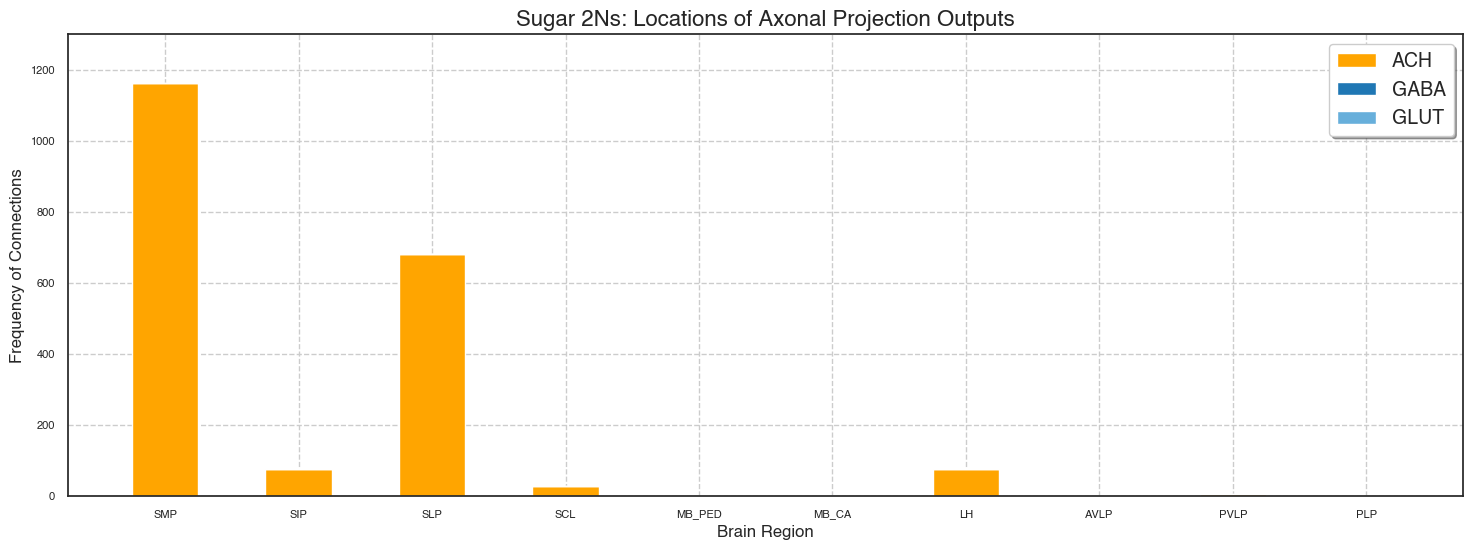

In [44]:
categories = ['SMP','SIP','SLP', \
                'SCL',\
                    'MB_PED','MB_CA',\
                        'LH',\
                            'AVLP','PVLP','PLP']

datasets = []
for category in categories:
    counts = pd.DataFrame(sugar2N_outputs[sugar2N_outputs['neuropil_remap'] == category])
    datasets.append(counts)

NTs = ['ACH','GABA','GLUT']

def count_NTs(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(dataset.query("nt_type == @NTs[0]")['syn_count'].sum())
        ACH_connections = np.array(variable1)
        variable2.append(dataset.query("nt_type == @NTs[1]")['syn_count'].sum())
        GABA_connections = np.array(variable2)
        variable3.append(dataset.query("nt_type == @NTs[2]")['syn_count'].sum())
        GLUT_connections = np.array(variable3)
    return ACH_connections,GABA_connections,GLUT_connections

variables = count_NTs(datasets, categories)

plt.figure(figsize=(18, 6))
plt.bar(categories, variables[0], color= 'orange', width = 0.5)
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5)
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5)

plt.xlabel('Brain Region')
plt.ylabel('Frequency of Connections')
plt.ylim(0,1300)
plt.title('Sugar 2Ns: Locations of Axonal Projection Outputs')
plt.legend(NTs)
plt.show()

# sum(sum(variables))/sugar2N_outputs.query("nt_type.isin(['ACH','GABA','GLUT']) & location_of_connection == 'outside_SEZ'")['syn_count'].sum()
# captures 97.8% of water outputs

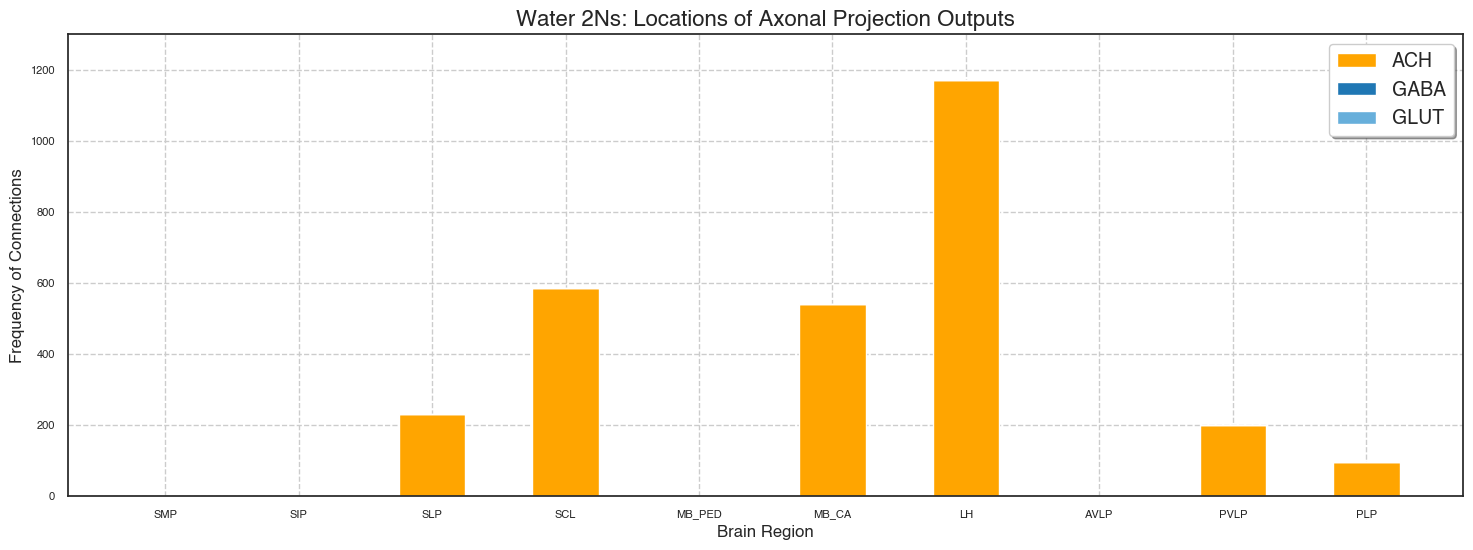

In [45]:
categories = ['SMP','SIP','SLP', \
                'SCL',\
                    'MB_PED','MB_CA',\
                        'LH',\
                            'AVLP','PVLP','PLP']

datasets = []
for category in categories:
    counts = pd.DataFrame(water2N_outputs[water2N_outputs['neuropil_remap'] == category])
    datasets.append(counts)

NTs = ['ACH','GABA','GLUT']

def count_NTs(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(dataset.query("nt_type == @NTs[0]")['syn_count'].sum())
        ACH_connections = np.array(variable1)
        variable2.append(dataset.query("nt_type == @NTs[1]")['syn_count'].sum())
        GABA_connections = np.array(variable2)
        variable3.append(dataset.query("nt_type == @NTs[2]")['syn_count'].sum())
        GLUT_connections = np.array(variable3)
    return ACH_connections,GABA_connections,GLUT_connections

variables = count_NTs(datasets, categories)

plt.figure(figsize=(18, 6))
plt.bar(categories, variables[0], color= 'orange', width = 0.5)
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5)
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5)

plt.xlabel('Brain Region')
plt.ylabel('Frequency of Connections')
plt.ylim(0,1300)
plt.title('Water 2Ns: Locations of Axonal Projection Outputs')
plt.legend(NTs)
plt.show()

# sum(sum(variables))/water2N_outputs.query("nt_type.isin(['ACH','GABA','GLUT']) & location_of_connection == 'outside_SEZ'")['syn_count'].sum()
# captures 96.5% of water outputs

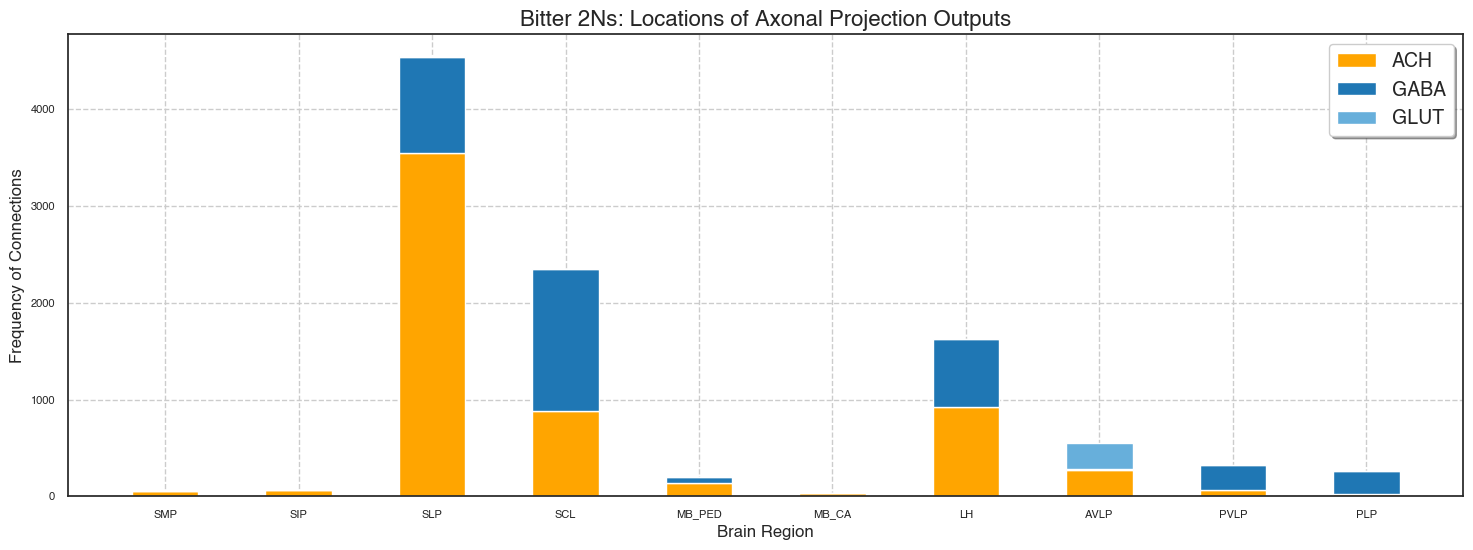

In [46]:
categories = ['SMP','SIP','SLP', \
                'SCL',\
                    'MB_PED','MB_CA',\
                        'LH',\
                            'AVLP','PVLP','PLP']

datasets = []
for category in categories:
    counts = pd.DataFrame(bitter2N_outputs[bitter2N_outputs['neuropil_remap'] == category])
    datasets.append(counts)

NTs = ['ACH','GABA','GLUT']

def count_NTs(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(dataset.query("nt_type == @NTs[0]")['syn_count'].sum())
        ACH_connections = np.array(variable1)
        variable2.append(dataset.query("nt_type == @NTs[1]")['syn_count'].sum())
        GABA_connections = np.array(variable2)
        variable3.append(dataset.query("nt_type == @NTs[2]")['syn_count'].sum())
        GLUT_connections = np.array(variable3)
    return ACH_connections,GABA_connections,GLUT_connections

variables = count_NTs(datasets, categories)

plt.figure(figsize=(18, 6))
plt.bar(categories, variables[0], color= 'orange', width = 0.5)
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5)
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5)

plt.xlabel('Brain Region')
plt.ylabel('Frequency of Connections')
plt.title('Bitter 2Ns: Locations of Axonal Projection Outputs')
plt.legend(NTs)
plt.show()

# sum(sum(variables))/bitter2N_outputs.query("nt_type.isin(['ACH','GABA','GLUT']) & location_of_connection == 'outside_SEZ'")['syn_count'].sum()
# captures 99.4% of bitter outputs

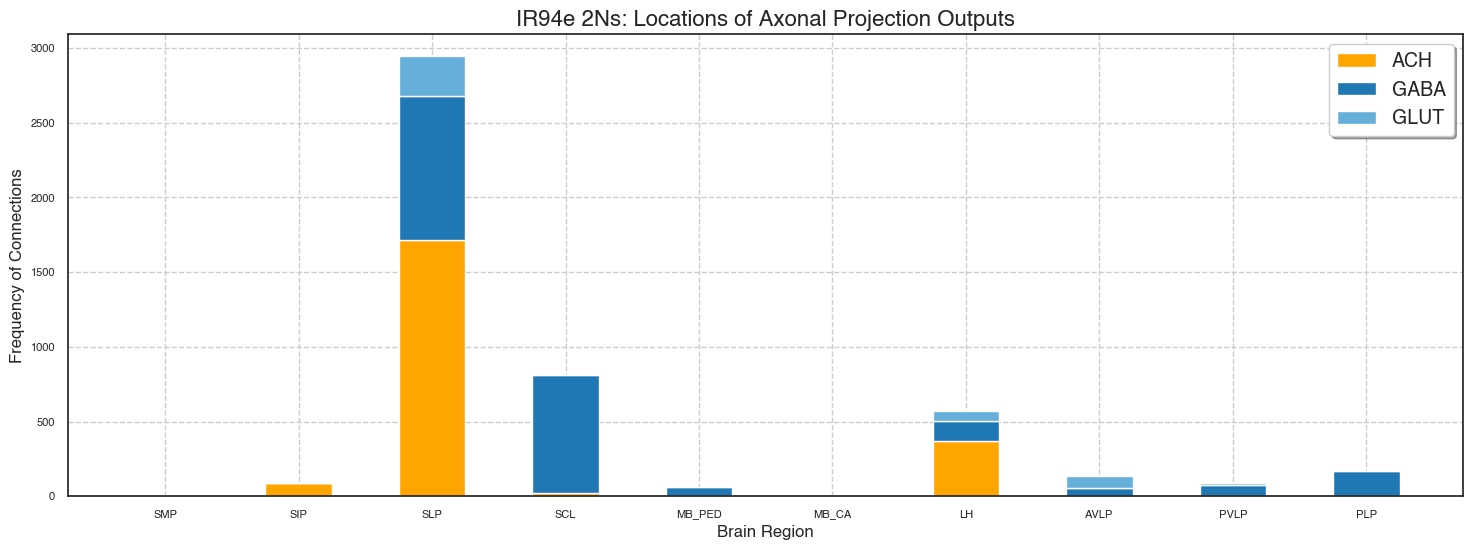

In [47]:
categories = ['SMP','SIP','SLP', \
                'SCL',\
                    'MB_PED','MB_CA',\
                        'LH',\
                            'AVLP','PVLP','PLP']

datasets = []
for category in categories:
    counts = pd.DataFrame(lowsalt2N_outputs[lowsalt2N_outputs['neuropil_remap'] == category])
    datasets.append(counts)

NTs = ['ACH','GABA','GLUT']

def count_NTs(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(dataset.query("nt_type == @NTs[0]")['syn_count'].sum())
        ACH_connections = np.array(variable1)
        variable2.append(dataset.query("nt_type == @NTs[1]")['syn_count'].sum())
        GABA_connections = np.array(variable2)
        variable3.append(dataset.query("nt_type == @NTs[2]")['syn_count'].sum())
        GLUT_connections = np.array(variable3)
    return ACH_connections,GABA_connections,GLUT_connections

variables = count_NTs(datasets, categories)

plt.figure(figsize=(18, 6))
plt.bar(categories, variables[0], color= 'orange', width = 0.5)
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5)
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5)

plt.xlabel('Brain Region')
plt.ylabel('Frequency of Connections')
plt.title('IR94e 2Ns: Locations of Axonal Projection Outputs')
plt.legend(NTs)
plt.show()

# sum(sum(variables))/lowsalt2N_outputs.query("nt_type.isin(['ACH','GABA','GLUT']) & location_of_connection == 'outside_SEZ'")['syn_count'].sum()
# captures 99.1% of IR94e outputs

## THIRD ORDER ANALYSES

### Defining a formula to identify third order neurons
- neuron downstream of taste 2Ns (that are not also GRNs)
- minimum of 10 synapses from a GRN to a 2N
- minimum of 10 synapses between the 2N and 3N 

In [48]:
def third_order(taste_second_order_connectivity, taste):
        connectivity = pd.merge(taste_second_order_connectivity.query("syn_count >= 10")['post_root_id'], connections[['pre_root_id','post_root_id','neuropil','syn_count','nt_type']], \
                left_on = 'post_root_id', right_on = 'pre_root_id', how = 'inner').query("syn_count >= 10")
        connectivity = connectivity.drop(columns = 'post_root_id_x')
        connectivity.rename(columns={'post_root_id_y': 'post_root_id'}, inplace=True)
        GRNs = pd.concat([sugar_GRNs['root_id'],  water_GRNs['root_id'], bitter_GRNs['root_id'],lowsalt_GRNs['root_id']])
        second_orders = pd.concat([sugar_2Ns['root_id'],  water_2Ns['root_id'], bitter_2Ns['root_id'],lowsalt_2Ns['root_id']])
        connectivity = connectivity[~connectivity['pre_root_id'].isin(GRNs)]
        connectivity = connectivity[~connectivity['post_root_id'].isin(pd.merge(GRNs,second_orders, how = 'outer')['root_id'])]
        connectivity = connectivity.drop_duplicates()
        third_orders = connectivity.groupby("post_root_id").agg({'pre_root_id' : 'nunique', 'syn_count' : 'sum'}).reset_index()
        third_orders.columns = ['root_id','upstream_' + taste + '_2Ns', taste + '_syn_count']
        third_orders['const'] = 1
        return connectivity, third_orders

In [49]:
sugar_third_order_connectivity, sugar_3Ns = third_order(sugar_second_order_connectivity, 'sugar')
water_third_order_connectivity, water_3Ns = third_order(water_second_order_connectivity, 'water')
bitter_third_order_connectivity, bitter_3Ns = third_order(bitter_second_order_connectivity, 'bitter')
lowsalt_third_order_connectivity, lowsalt_3Ns = third_order(lowsalt_second_order_connectivity, 'lowsalt')


### Importing more informatiotn about 3Ns from flywire's data repository

In [50]:
labels = pd.read_csv('/Users/SydneyWalker/Downloads/labels.csv.gz')[['root_id','label']]
neuropil_synapse = pd.read_csv('/Users/SydneyWalker/Downloads/neuropil_synapse_table.csv.gz')[['root_id','input synapses','output synapses']]
neuropil_synapse.rename(columns={'input synapses': 'input_synapses','output synapses': 'output_synapses'}, inplace=True)
classification = pd.read_csv('/Users/SydneyWalker/Downloads/classification.csv.gz')[['root_id','side']]
neurons = pd.read_csv('/Users/SydneyWalker/Downloads/neurons (1).csv.gz')[['root_id','nt_type']]

taste3N_data = pd.merge(labels, pd.merge(neurons, pd.merge(classification, neuropil_synapse, on='root_id'), on='root_id'), on='root_id')

In [51]:
sugar_3Ns = pd.merge(sugar_3Ns, taste3N_data, on = 'root_id', how = 'inner')
water_3Ns = pd.merge(water_3Ns, taste3N_data, on = 'root_id', how = 'inner')
bitter_3Ns = pd.merge(bitter_3Ns, taste3N_data, on = 'root_id', how = 'inner')
lowsalt_3Ns = pd.merge(lowsalt_3Ns, taste3N_data, on = 'root_id', how = 'inner')

### Venn diagram to visualize crossover within third order neurons

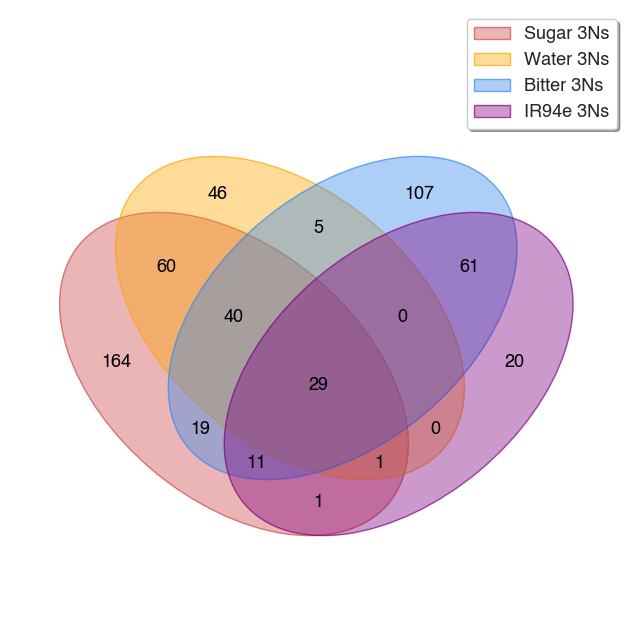

In [52]:
sugar_list = {'{}'.format(value) for value in sugar_3Ns['root_id'].unique()}
sugar_dict = {'Sugar 3Ns': sugar_list}

water_list = {'{}'.format(value) for value in water_3Ns['root_id'].unique()}
water_dict = {'Water 3Ns': water_list}


bitter_list = {'{}'.format(value) for value in bitter_3Ns['root_id'].unique()}
bitter_dict = {'Bitter 3Ns': bitter_list}

lowsalt_list = {'{}'.format(value) for value in lowsalt_3Ns['root_id'].unique()}
lowsalt_dict = {'IR94e 3Ns': lowsalt_list}

colors = ('#cf4848','orange','#3489eb','purple')
crossover = {**sugar_dict, **water_dict, **bitter_dict, **lowsalt_dict}
venn(crossover, cmap = ListedColormap(colors))
plt.show()

### Looking at unthresholded axonal outputs of third order neurons
- neuron downstream of third order neuron 
- minimum of 5 synapses with second orders
- not filtering out "fourth orders" that are also GRNs, second orders, third orders


In [53]:
sugar3N_outputs = neuronal_outputs(sugar_3Ns)
water3N_outputs = neuronal_outputs(water_3Ns)
bitter3N_outputs = neuronal_outputs(bitter_3Ns)
lowsalt3N_outputs = neuronal_outputs(lowsalt_3Ns)

### Quantifying 3N to 3N communication

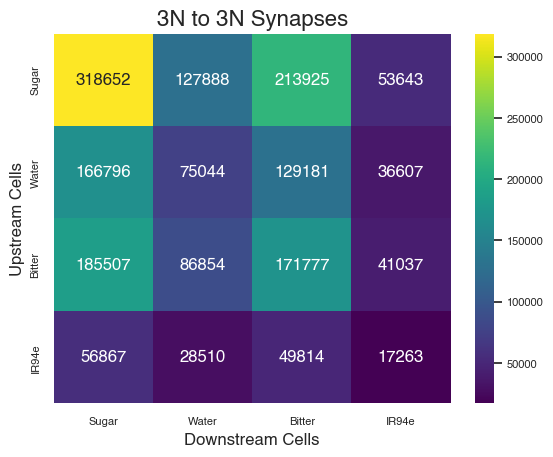

In [54]:
def heatmap(taste3N_outputs):
    df = [sugar_3Ns, water_3Ns, bitter_3Ns, lowsalt_3Ns]
    taste_connectivity = []
    array = []
    for i in range(len(df)): 
        taste_connectivity.append(pd.merge(taste3N_outputs, df[i], left_on = 'post_root_id', right_on = 'root_id', how = 'inner'))
        array.append(taste_connectivity[i]['syn_count'].sum())
    return array

heatmap_3Ns = [heatmap(sugar3N_outputs),heatmap(water3N_outputs), heatmap(bitter3N_outputs), heatmap(lowsalt3N_outputs)]
row_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
col_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
sns.heatmap(heatmap_3Ns, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels) 
plt.title("3N to 3N Synapses")
plt.ylabel("Upstream Cells")
plt.xlabel("Downstream Cells")
plt.show()

### Excitatory 3N to 3N communication

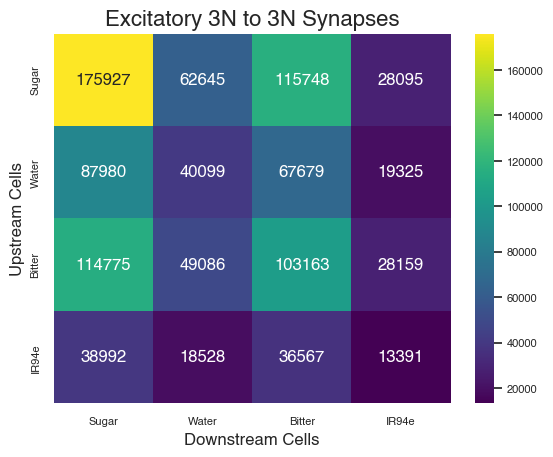

In [55]:
heatmap_3Ns = [heatmap(sugar3N_outputs.query("nt_type == 'ACH'")),heatmap(water3N_outputs.query("nt_type == 'ACH'")), \
               heatmap(bitter3N_outputs.query("nt_type == 'ACH'")), heatmap(lowsalt3N_outputs.query("nt_type == 'ACH'"))]
row_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
col_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
sns.heatmap(heatmap_3Ns, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels)  
plt.title("Excitatory 3N to 3N Synapses")
plt.ylabel("Upstream Cells")
plt.xlabel("Downstream Cells")
plt.show()

### Inhibitory 3N to 3N communication

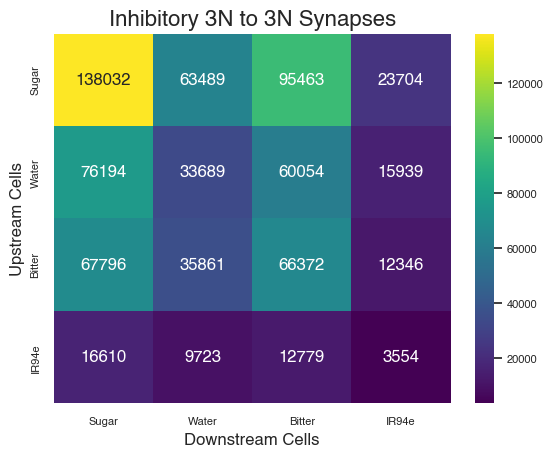

In [56]:
heatmap_3Ns = [heatmap(sugar3N_outputs.query("nt_type.isin(['GABA','GLUT'])")),heatmap(water3N_outputs.query("nt_type.isin(['GABA','GLUT'])")), \
               heatmap(bitter3N_outputs.query("nt_type.isin(['GABA','GLUT'])")), heatmap(lowsalt3N_outputs.query("nt_type.isin(['GABA','GLUT'])"))]
row_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
col_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
sns.heatmap(heatmap_3Ns, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels)  
plt.title("Inhibitory 3N to 3N Synapses")
plt.ylabel("Upstream Cells")
plt.xlabel("Downstream Cells")
plt.show()

### Identifying "unfiltered" third order neurons
- neuron downstream of second order neuron 
- minimum of 10 synapses with second order that has 10 synapses with GRN
- not filtering out "third orders" that are also GRNs, second orders 
- minimum of 10 synapses with GRN if also downstream from GRNs

In [57]:
def unfiltered_third_order(tasteGRN_outputs, taste_2Ns, taste):
    data = tasteGRN_outputs.query("syn_count >= 10")['post_root_id']
    taste_2Ns = taste_2Ns[taste_2Ns['root_id'].isin(data)]
    connectivity = pd.merge(taste_2Ns['root_id'], connections[['pre_root_id', 'post_root_id','syn_count']], left_on = 'root_id', right_on = 'pre_root_id', how = 'inner').query("syn_count >= 10")
    third_orders = connectivity.groupby("post_root_id").agg({'pre_root_id' : 'nunique', 'syn_count' : 'sum'}).reset_index()
    third_orders.columns = ['root_id','upstream_' + taste + '_neurons', taste + '_syn_count']
    third_orders['const'] = 1
    return third_orders

sugar3Ns_unfiltered = unfiltered_third_order(sugarGRN_outputs, sugar_2Ns, 'sugar')
water3Ns_unfiltered = unfiltered_third_order(waterGRN_outputs, water_2Ns, 'water')
bitter3Ns_unfiltered = unfiltered_third_order(bitterGRN_outputs, bitter_2Ns, 'bitter')
lowsalt3Ns_unfiltered = unfiltered_third_order(lowsaltGRN_outputs, lowsalt_2Ns, 'lowsalt')

### Heatmap to see the overlap in connectivity between modalites for either GRN or 2N --> 3Ns

In [58]:
first_order_connectivity = pd.concat([sugarGRN_outputs, waterGRN_outputs, bitterGRN_outputs, lowsaltGRN_outputs])[['post_root_id','syn_count']].query("syn_count >= 10")
connectivity = pd.merge(first_order_connectivity['post_root_id'], connections[['pre_root_id', 'post_root_id','syn_count']], left_on = 'post_root_id', right_on = 'pre_root_id', how = 'inner') #.query("syn_count_y >= 10")
connectivity = connectivity.drop(columns = 'post_root_id_x')
connectivity.rename(columns={'post_root_id_y': 'post_root_id'}, inplace=True)
connectivity

IDs_GRNs_2Ns = pd.concat([sugar_GRNs['root_id'],  water_GRNs['root_id'], bitter_GRNs['root_id'],lowsalt_GRNs['root_id'], \
                      sugar_2Ns['root_id'],  water_2Ns['root_id'], bitter_2Ns['root_id'],lowsalt_2Ns['root_id']])

heatmap_data = connections[connections['pre_root_id'].isin(IDs_GRNs_2Ns) &
    connections['post_root_id'].isin(connectivity['post_root_id'])]

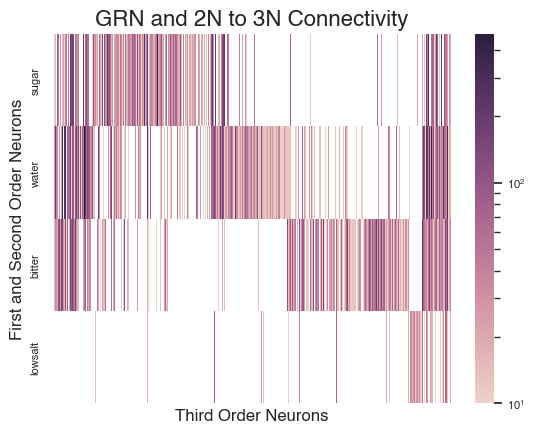

In [59]:
IDs_GRNs_2Ns = pd.concat([sugar_GRNs['root_id'],  water_GRNs['root_id'], bitter_GRNs['root_id'],lowsalt_GRNs['root_id'], \
                      sugar_2Ns['root_id'],  water_2Ns['root_id'], bitter_2Ns['root_id'],lowsalt_2Ns['root_id']], axis = 0)
IDs_3Ns = pd.concat([sugar_3Ns['root_id'],  water_3Ns['root_id'], bitter_3Ns['root_id'],lowsalt_3Ns['root_id']], axis = 0)

heatmap_data = connections[connections['pre_root_id'].isin(IDs_GRNs_2Ns) &
    connections['post_root_id'].isin(IDs_3Ns)].query("syn_count >= 10")

heatmap_data['post_root_id_group'] = ' '
for entry in heatmap_data['post_root_id']:
    heatmap_data.loc[heatmap_data['post_root_id'] == entry, 'post_root_id_group'] = ' '
    group = ''
    if entry in sugar_3Ns['root_id'].values:
        group += 'sugar'
    if entry in water_3Ns['root_id'].values:
        group += 'water'
    if entry in bitter_3Ns['root_id'].values:
        group += 'bitter'
    if entry in lowsalt_3Ns['root_id'].values:
        group += 'lowsalt'
    if group:
        heatmap_data.loc[heatmap_data['post_root_id'] == entry, 'post_root_id_group'] = group

heatmap_data['pre_root_id_group'] = ' '
for entry in heatmap_data['pre_root_id']:
    if entry in water_2Ns['root_id'].values or entry in water_GRNs['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'water'
    elif entry in sugar_2Ns['root_id'].values or entry in sugar_GRNs['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'sugar'
    elif entry in bitter_2Ns['root_id'].values or entry in bitter_GRNs['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'bitter'
    elif entry in lowsalt_2Ns['root_id'].values or entry in lowsalt_GRNs['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'lowsalt'
    else:
        pass

custom_order_3Ns = ['sugarbitter', 'sugarwaterbitter', 'sugarlowsalt', 'sugar', 'sugarwater', 'sugarwaterlowsalt', 'water', 'waterlowsalt', \
                    'waterbitter', 'waterbitterlowsalt', 'bitter', 'sugarbitterlosalt', 'bitterlowsalt', 'lowsalt', 'sugarwaterbitterlowsalt']
custom_order_GRNs_2Ns = ['sugar','water','bitter','lowsalt'] 
heatmap_data['post_root_id_group'] = pd.Categorical(heatmap_data['post_root_id_group'], categories=custom_order_3Ns, ordered=True)
heatmap_data['pre_root_id_group'] = pd.Categorical(heatmap_data['pre_root_id_group'], categories=custom_order_GRNs_2Ns, ordered=True)
df_sorted = heatmap_data.sort_values(by='post_root_id_group')

heatmap_matrix = df_sorted.pivot_table(index = 'pre_root_id_group', columns = 'post_root_id', values = 'syn_count', aggfunc='sum', fill_value = 0)
desired_column_order = df_sorted['post_root_id'].unique()
heatmap_matrix = heatmap_matrix[desired_column_order]

sns.heatmap(heatmap_matrix, norm=LogNorm(),cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=False)
plt.title('GRN and 2N to 3N Connectivity')
plt.xlabel('Third Order Neurons')
plt.ylabel('First and Second Order Neurons')
plt.show()

In [60]:

           
# heatmap_data['post_root_id_group'] = ' '
# for entry in heatmap_data['post_root_id']:
#     heatmap_data.loc[heatmap_data['post_root_id'] == entry, 'post_root_id_group'] = ' '
#     group = ''
#     if entry in sugar_3Ns['root_id'].values:
#         group += 'sugar'
#     if entry in water_3Ns['root_id'].values:
#         group += 'water'
#     if entry in bitter_3Ns['root_id'].values:
#         group += 'bitter'
#     if entry in lowsalt_3Ns['root_id'].values:
#         group += 'lowsalt'
#     if group:
#         heatmap_data.loc[heatmap_data['post_root_id'] == entry, 'post_root_id_group'] = group
    

# heatmap_data['pre_root_id_group'] = ' '
# for entry in heatmap_data['pre_root_id']:
#     if entry in water_2Ns['root_id'].values or entry in water_GRNs['root_id'].values:
#         heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'water'
#     elif entry in sugar_2Ns['root_id'].values or entry in sugar_GRNs['root_id'].values:
#         heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'sugar'
#     elif entry in bitter_2Ns['root_id'].values or entry in bitter_GRNs['root_id'].values:
#         heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'bitter'
#     elif entry in lowsalt_2Ns['root_id'].values or entry in lowsalt_GRNs['root_id'].values:
#         heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'lowsalt'
#     else:
#         pass
    
# custom_order_3Ns = ['sugarbitter', 'sugarwaterbitter', 'sugarlowsalt', 'sugar', 'sugarwater', 'sugarwaterlowsalt', 'water', 'waterlowsalt', \
#                     'waterbitter', 'waterbitterlowsalt', 'bitter', 'sugarbitterlosalt', 'bitterlowsalt', 'lowsalt', 'sugarwaterbitterlowsalt']
# custom_order_GRNs_2Ns = ['sugar','water','bitter','lowsalt'] 
# heatmap_data['post_root_id_group'] = pd.Categorical(heatmap_data['post_root_id_group'], categories=custom_order_3Ns, ordered=True)
# heatmap_data['pre_root_id_group'] = pd.Categorical(heatmap_data['pre_root_id_group'], categories=custom_order_GRNs_2Ns, ordered=True)
# df_sorted = heatmap_data.sort_values(by='post_root_id_group')

# heatmap_matrix = df_sorted.pivot_table(index = 'pre_root_id_group', columns = 'post_root_id', values = 'syn_count', aggfunc='sum', fill_value = 0)
# desired_column_order = df_sorted['post_root_id'].unique()
# heatmap_matrix = heatmap_matrix[desired_column_order]

# sns.heatmap(heatmap_matrix, norm=LogNorm(),cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=False)
# plt.title('GRN and 2N to 3N Connectivity')
# plt.xlabel('Third Order Neurons')
# plt.ylabel('First and Second Order Neurons')
# plt.show()

### Heatmap to see the overlap in connectivity between modalites for strictly 2N --> 3Ns

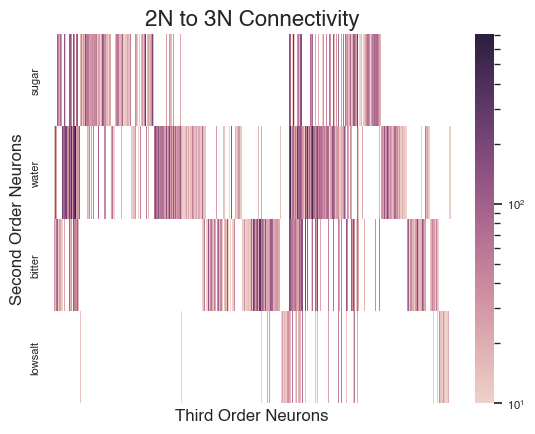

In [61]:
heatmap_data = pd.concat([sugar_third_order_connectivity,water_third_order_connectivity,bitter_third_order_connectivity,lowsalt_third_order_connectivity], axis = 0)

heatmap_data['post_root_id_group'] = ' '
for entry in heatmap_data['post_root_id']:
    heatmap_data.loc[heatmap_data['post_root_id'] == entry, 'post_root_id_group'] = ' '
    group = ''
    if entry in sugar_3Ns['root_id'].values:
        group += 'sugar'
    if entry in water_3Ns['root_id'].values:
        group += 'water'
    if entry in bitter_3Ns['root_id'].values:
        group += 'bitter'
    if entry in lowsalt_3Ns['root_id'].values:
        group += 'lowsalt'
    if group:
        heatmap_data.loc[heatmap_data['post_root_id'] == entry, 'post_root_id_group'] = group
    

heatmap_data['pre_root_id_group'] = ' '
for entry in heatmap_data['pre_root_id']:
    if entry in water_2Ns['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'water'
    elif entry in sugar_2Ns['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'sugar'
    elif entry in bitter_2Ns['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'bitter'
    elif entry in lowsalt_2Ns['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'lowsalt'
    else:
        pass
    
custom_order_3Ns = ['sugarbitter', 'sugarwaterbitter', 'sugarlowsalt', 'sugar', 'sugarwater', 'sugarwaterlowsalt', 'water', 'waterlowsalt', \
                    'waterbitter', 'waterbitterlowsalt', 'bitter', 'sugarbitterlosalt', 'bitterlowsalt', 'lowsalt', 'sugarwaterbitterlowsalt']
custom_order_2Ns = ['sugar','water','bitter','lowsalt'] 
heatmap_data['post_root_id_group'] = pd.Categorical(heatmap_data['post_root_id_group'], categories=custom_order_3Ns, ordered=True)
heatmap_data['pre_root_id_group'] = pd.Categorical(heatmap_data['pre_root_id_group'], categories=custom_order_2Ns, ordered=True)
df_sorted = heatmap_data.sort_values(by='post_root_id_group')

heatmap_matrix = df_sorted.pivot_table(index = 'pre_root_id_group', columns = 'post_root_id', values = 'syn_count', aggfunc='sum', fill_value = 0)
desired_column_order = df_sorted['post_root_id'].unique()
heatmap_matrix = heatmap_matrix[desired_column_order]

sns.heatmap(heatmap_matrix, norm=LogNorm(),cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=False)
plt.title('2N to 3N Connectivity')
plt.xlabel('Third Order Neurons')
plt.ylabel('Second Order Neurons')
plt.show()

### Adding a column for % input coming from 2Ns + average upstream synapses

In [62]:
sugar_3Ns['%_sugar_input'] = sugar_3Ns['sugar_syn_count']/sugar_3Ns['input_synapses']*100
water_3Ns['%_water_input'] = water_3Ns['water_syn_count']/water_3Ns['input_synapses']*100
bitter_3Ns['%_bitter_input'] = bitter_3Ns['bitter_syn_count']/bitter_3Ns['input_synapses']*100
lowsalt_3Ns['%_lowsalt_input'] = lowsalt_3Ns['lowsalt_syn_count']/lowsalt_3Ns['input_synapses']*100

In [63]:
sugar_3Ns['avg_upstream_synapses'] = sugar_3Ns['sugar_syn_count']/sugar_3Ns['upstream_sugar_2Ns']
water_3Ns['avg_upstream_synapses'] = water_3Ns['water_syn_count']/water_3Ns['upstream_water_2Ns']
bitter_3Ns['avg_upstream_synapses'] = bitter_3Ns['bitter_syn_count']/bitter_3Ns['upstream_bitter_2Ns']
lowsalt_3Ns['avg_upstream_synapses'] = lowsalt_3Ns['lowsalt_syn_count']/lowsalt_3Ns['upstream_lowsalt_2Ns']

In [64]:
sugar3Ns_unfiltered['avg_upstream_synapses'] = sugar3Ns_unfiltered['sugar_syn_count']/sugar3Ns_unfiltered['upstream_sugar_neurons']
water3Ns_unfiltered['avg_upstream_synapses'] = water3Ns_unfiltered['water_syn_count']/water3Ns_unfiltered['upstream_water_neurons']
bitter3Ns_unfiltered['avg_upstream_synapses'] = bitter3Ns_unfiltered['bitter_syn_count']/bitter3Ns_unfiltered['upstream_bitter_neurons']
lowsalt3Ns_unfiltered['avg_upstream_synapses'] = lowsalt3Ns_unfiltered['lowsalt_syn_count']/lowsalt3Ns_unfiltered['upstream_lowsalt_neurons']

### Visualizing the proportion of input 3Ns receive (# syanpses vs # cells) + OLS modeling to see if there's a significant relationship between our variables

In [65]:
def synapse_scatter_3Ns(taste_3Ns, taste, color, title):
    x = taste_3Ns['upstream_' + taste + '_2Ns']
    y = taste_3Ns['avg_upstream_synapses']
    def objective(x, a, b):
        return a * x + b
    popt, _ = curve_fit(objective, x, y)
    a, b = popt
    fig, ax = plt.subplots()
    sns.stripplot(data=taste_3Ns, x='upstream_' + taste + '_2Ns', y="avg_upstream_synapses", color = color)
    x_line = np.arange(0, max(x)+1, 1)
    y_line = objective(x_line, a, b)
    ax.plot(x_line, y_line, '--', color='black')
    ax.set_xticks(np.arange(0, max(x) + 1, step=1))
    ax.set_yticks(np.arange(0, max(y) + 1, step=40))
    ax.set_xlabel('# Upstream 2Ns')
    ax.set_ylabel('Average # of Input Synapses')
    ax.set_title('Convergence Within ' + title + ' 3Ns')
    plt.show()
    formula = ('y = %.5f * x + %.5f ' % (a, b))
    return formula

In [66]:
def unfiltered_synapse_scatter_3Ns(taste3Ns_unfiltered, taste, color, title):
    x = taste3Ns_unfiltered['upstream_' + taste + '_neurons']
    y = taste3Ns_unfiltered['avg_upstream_synapses']
    def objective(x, a, b):
        return a * x + b
    popt, _ = curve_fit(objective, x, y)
    a, b = popt
    fig, ax = plt.subplots()
    sns.stripplot(data=taste3Ns_unfiltered, x='upstream_' + taste + '_neurons', y="avg_upstream_synapses", color = color)
    x_line = np.arange(0, max(x)+1, 1)
    y_line = objective(x_line, a, b)
    ax.plot(x_line, y_line, '--', color='black')
    ax.set_xticks(np.arange(0, max(x) + 1, step=1))
    ax.set_yticks(np.arange(0, max(y) + 1, step=40))
    ax.set_xlabel('# Upstream GRNs or 2Ns')
    ax.set_ylabel('Average # of Input Synapses')
    ax.set_title('Convergence Within ' + title + ' 3Ns')
    plt.show()
    formula = ('y = %.5f * x + %.5f ' % (a, b))
    return formula

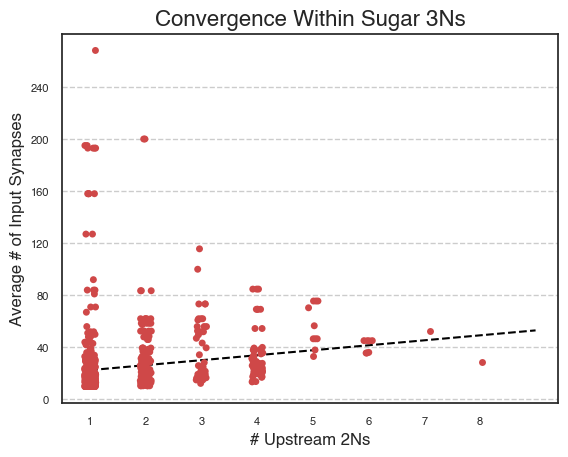

'y = 3.81347 * x + 22.54472 '

In [67]:
synapse_scatter_3Ns(sugar_3Ns, 'sugar', '#cf4848', 'Sugar')

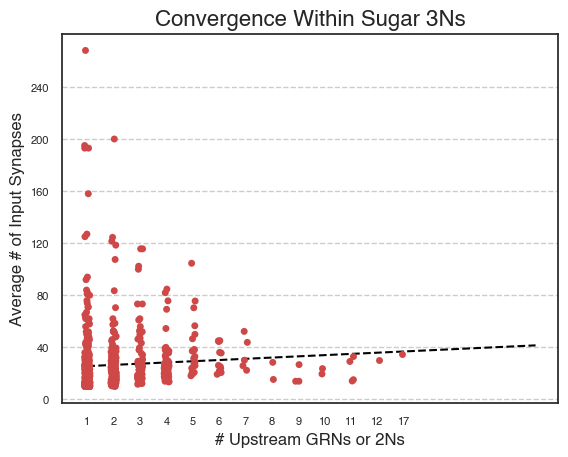

'y = 0.93750 * x + 25.60939 '

In [68]:
unfiltered_synapse_scatter_3Ns(sugar3Ns_unfiltered, 'sugar', '#cf4848', 'Sugar')

In [69]:
sugar_model = sm.OLS(sugar_3Ns['avg_upstream_synapses'], sugar_3Ns[['const','upstream_sugar_2Ns']]).fit()
sugar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.021
Model:                               OLS   Adj. R-squared:                  0.020
Method:                    Least Squares   F-statistic:                     12.90
Date:                   Fri, 17 May 2024   Prob (F-statistic):           0.000356
Time:                           14:27:36   Log-Likelihood:                -2882.7
No. Observations:                    596   AIC:                             5769.
Df Residuals:                        594   BIC:                             5778.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 22.5447      2.256      9.991      0.000      18.113      26.976
upstream_sugar_2Ns     3.8135      1.062      3.592      0.000       1.728       5.899
==============================================================================
Omnibus:                      529.260   Durbin-Watson:                   1.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11257.837
Skew:                           4.041   Prob(JB):                         0.00
Kurtosis:                      22.698   Cond. No.                         4.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
sugar_model = sm.OLS(sugar3Ns_unfiltered['avg_upstream_synapses'], sugar3Ns_unfiltered[['const','upstream_sugar_neurons']]).fit()
sugar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.004
Model:                               OLS   Adj. R-squared:                  0.003
Method:                    Least Squares   F-statistic:                     2.612
Date:                   Fri, 17 May 2024   Prob (F-statistic):              0.107
Time:                           14:27:36   Log-Likelihood:                -2877.7
No. Observations:                    614   AIC:                             5759.
Df Residuals:                        612   BIC:                             5768.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     25.6094      1.645     15.571      0.000      22.379      28.839
upstream_sugar_neurons     0.9375      0.580      1.616      0.107      -0.202       2.077
==============================================================================
Omnibus:                      563.184   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16097.612
Skew:                           4.120   Prob(JB):                         0.00
Kurtosis:                      26.693   Cond. No.                         4.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

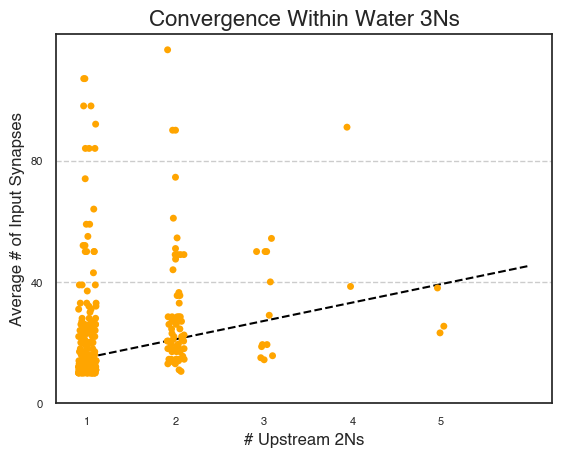

'y = 6.05269 * x + 15.05034 '

In [71]:
synapse_scatter_3Ns(water_3Ns, 'water', 'orange','Water')


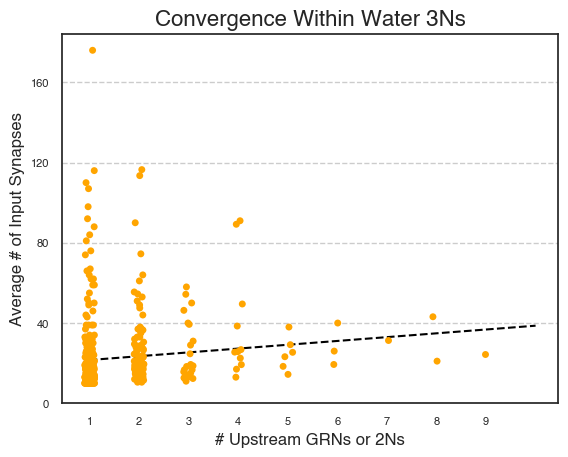

'y = 1.90156 * x + 21.56051 '

In [72]:
unfiltered_synapse_scatter_3Ns(water3Ns_unfiltered, 'water', 'orange', 'Water')

In [73]:
water_model = sm.OLS(water_3Ns['avg_upstream_synapses'], water_3Ns[['const','upstream_water_2Ns']]).fit()
water_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.047
Model:                               OLS   Adj. R-squared:                  0.044
Method:                    Least Squares   F-statistic:                     15.68
Date:                   Fri, 17 May 2024   Prob (F-statistic):           9.25e-05
Time:                           14:27:36   Log-Likelihood:                -1380.4
No. Observations:                    319   AIC:                             2765.
Df Residuals:                        317   BIC:                             2772.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.0503      2.307      6.523      0.000      10.511      19.590
upstream_water_2Ns     6.0527      1.528      3.960      0.000       3.046       9.060
==============================================================================
Omnibus:                      197.031   Durbin-Watson:                   1.344
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1177.748
Skew:                           2.675   Prob(JB):                    1.80e-256
Kurtosis:                      10.745   Cond. No.                         4.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
water_model = sm.OLS(water3Ns_unfiltered['avg_upstream_synapses'], water3Ns_unfiltered[['const','upstream_water_neurons']]).fit()
water_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.011
Model:                               OLS   Adj. R-squared:                  0.009
Method:                    Least Squares   F-statistic:                     4.291
Date:                   Fri, 17 May 2024   Prob (F-statistic):             0.0390
Time:                           14:27:36   Log-Likelihood:                -1700.8
No. Observations:                    383   AIC:                             3406.
Df Residuals:                        381   BIC:                             3413.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     21.5605      1.818     11.856      0.000      17.985      25.136
upstream_water_neurons     1.9016      0.918      2.071      0.039       0.097       3.706
==============================================================================
Omnibus:                      276.612   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3028.733
Skew:                           3.059   Prob(JB):                         0.00
Kurtosis:                      15.343   Cond. No.                         4.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

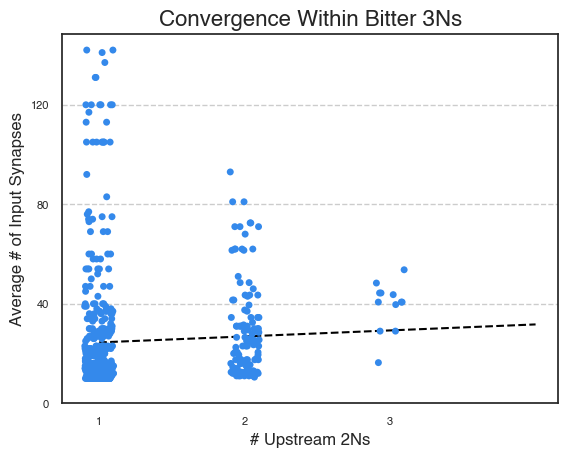

'y = 2.41379 * x + 24.45357 '

In [75]:
synapse_scatter_3Ns(bitter_3Ns, 'bitter', '#3489eb','Bitter')

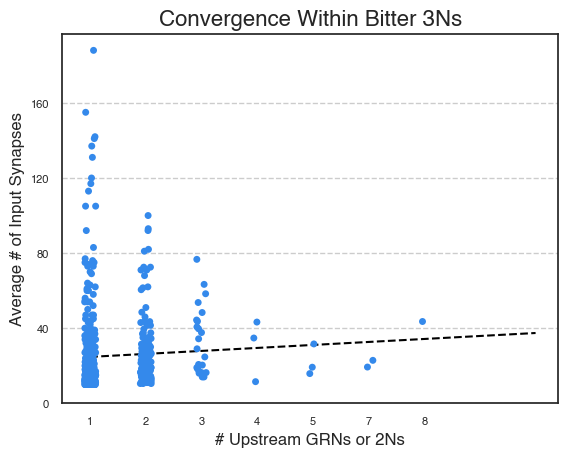

'y = 1.59022 * x + 24.70071 '

In [76]:
unfiltered_synapse_scatter_3Ns(bitter3Ns_unfiltered, 'bitter', '#3489eb', 'Bitter')

In [77]:
bitter_model = sm.OLS(bitter_3Ns['avg_upstream_synapses'], bitter_3Ns[['const','upstream_bitter_2Ns']]).fit()
bitter_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.002
Model:                               OLS   Adj. R-squared:                  0.000
Method:                    Least Squares   F-statistic:                     1.209
Date:                   Fri, 17 May 2024   Prob (F-statistic):              0.272
Time:                           14:27:37   Log-Likelihood:                -2472.1
No. Observations:                    532   AIC:                             4948.
Df Residuals:                        530   BIC:                             4957.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  24.4536      3.027      8.077      0.000      18.506      30.401
upstream_bitter_2Ns     2.4138      2.195      1.100      0.272      -1.898       6.726
==============================================================================
Omnibus:                      283.840   Durbin-Watson:                   0.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1397.113
Skew:                           2.462   Prob(JB):                    4.18e-304
Kurtosis:                       9.227   Cond. No.                         5.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
bitter_model = sm.OLS(bitter3Ns_unfiltered['avg_upstream_synapses'], bitter3Ns_unfiltered[['const','upstream_bitter_neurons']]).fit()
bitter_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.003
Model:                               OLS   Adj. R-squared:                  0.001
Method:                    Least Squares   F-statistic:                     1.442
Date:                   Fri, 17 May 2024   Prob (F-statistic):              0.230
Time:                           14:27:37   Log-Likelihood:                -2177.5
No. Observations:                    475   AIC:                             4359.
Df Residuals:                        473   BIC:                             4367.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      24.7007      2.206     11.198      0.000      20.366      29.035
upstream_bitter_neurons     1.5902      1.324      1.201      0.230      -1.012       4.192
==============================================================================
Omnibus:                      318.325   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2982.673
Skew:                           2.907   Prob(JB):                         0.00
Kurtosis:                      13.812   Cond. No.                         4.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

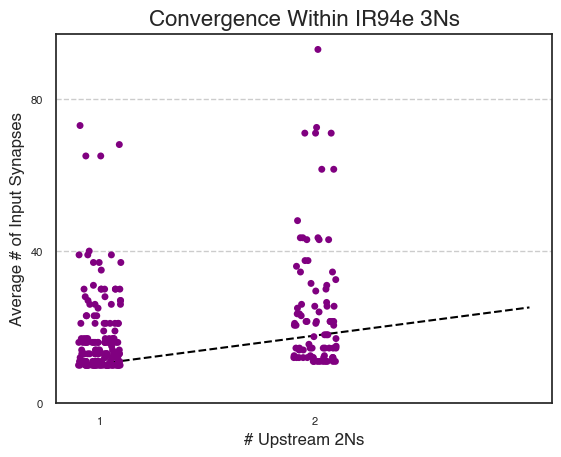

'y = 7.40978 * x + 10.37009 '

In [79]:
synapse_scatter_3Ns(lowsalt_3Ns, 'lowsalt', 'purple','IR94e')

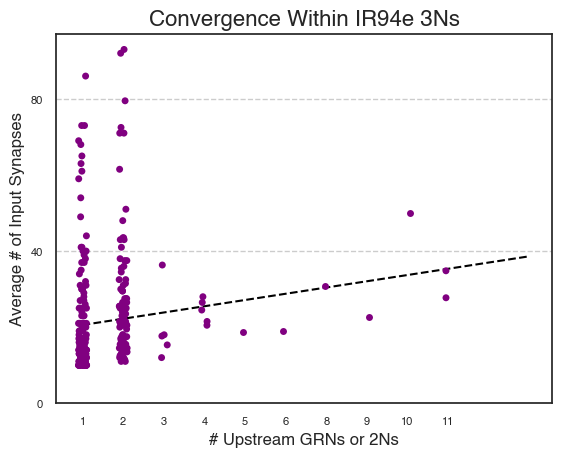

'y = 1.64185 * x + 20.57355 '

In [80]:
unfiltered_synapse_scatter_3Ns(lowsalt3Ns_unfiltered, 'lowsalt', 'purple', 'IR94e')

In [81]:
lowsalt_model = sm.OLS(lowsalt_3Ns['avg_upstream_synapses'], lowsalt_3Ns[['const','upstream_lowsalt_2Ns']]).fit()
lowsalt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.065
Model:                               OLS   Adj. R-squared:                  0.061
Method:                    Least Squares   F-statistic:                     16.94
Date:                   Fri, 17 May 2024   Prob (F-statistic):           5.29e-05
Time:                           14:27:37   Log-Likelihood:                -988.34
No. Observations:                    246   AIC:                             1981.
Df Residuals:                        244   BIC:                             1988.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.3701      2.585      4.012      0.000       5.279      15.461
upstream_lowsalt_2Ns     7.4098      1.800      4.116      0.000       3.863      10.956
==============================================================================
Omnibus:                      131.044   Durbin-Watson:                   1.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              575.008
Skew:                           2.256   Prob(JB):                    1.38e-125
Kurtosis:                       8.978   Cond. No.                         6.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
lowsalt_model = sm.OLS(lowsalt3Ns_unfiltered['avg_upstream_synapses'], lowsalt3Ns_unfiltered[['const','upstream_lowsalt_neurons']]).fit()
lowsalt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.020
Model:                               OLS   Adj. R-squared:                  0.016
Method:                    Least Squares   F-statistic:                     5.134
Date:                   Fri, 17 May 2024   Prob (F-statistic):             0.0243
Time:                           14:27:37   Log-Likelihood:                -1083.2
No. Observations:                    259   AIC:                             2170.
Df Residuals:                        257   BIC:                             2178.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       20.5736      1.540     13.359      0.000      17.541      23.606
upstream_lowsalt_neurons     1.6418      0.725      2.266      0.024       0.215       3.069
==============================================================================
Omnibus:                      125.365   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              442.097
Skew:                           2.148   Prob(JB):                     1.00e-96
Kurtosis:                       7.744   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Looking at the synapse distribution for each modality

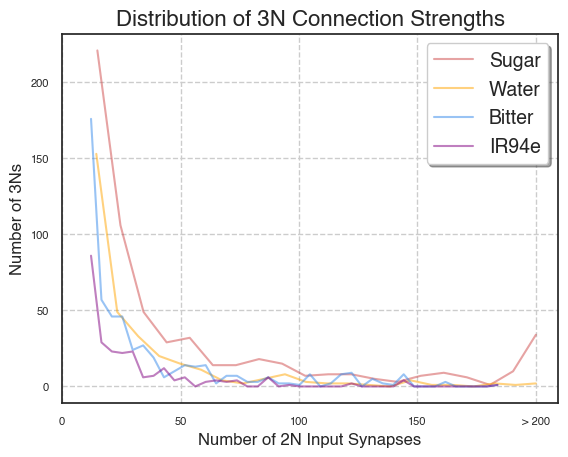

In [83]:
def synapse_distribution_3Ns(taste_3Ns, taste):
    data = taste_3Ns[taste + '_syn_count']
    num_bins = 40 
    bins = np.linspace(min(data), max(data), num_bins + 1)
    frequencies, bin_edges = np.histogram(data, bins)
    bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
    df = pd.DataFrame({'labels': bin_labels, 'frequencies' : frequencies})
    df = df.sort_values(by = 'labels', ascending= True)
    def custom_label(label):
        if label > 200:
            return '200'
        else:
            return label
    df['label_category'] = df['labels'].apply(custom_label)
    df = df.groupby('label_category', as_index=False)['frequencies'].sum()
    return df

sugar_synapse_distribution = synapse_distribution_3Ns(sugar_3Ns, 'sugar')
water_synapse_distribution = synapse_distribution_3Ns(water_3Ns, 'water')
bitter_synapse_distribution = synapse_distribution_3Ns(bitter_3Ns, 'bitter')
lowsalt_synapse_distribution = synapse_distribution_3Ns(lowsalt_3Ns, 'lowsalt')

dataframes = [sugar_synapse_distribution, water_synapse_distribution, bitter_synapse_distribution, lowsalt_synapse_distribution]
labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
colors = ['#cf4848', 'orange', '#3489eb','purple']

for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['label_category'], df['frequencies'], label=label, alpha=0.5, color=color)

xlabels = np.array(np.arange(0,201, 50), dtype= str)
xlabels[-1] = '> 200'
plt.xticks(ticks = 50 * np.arange(len(xlabels)) , labels = xlabels)
plt.xlabel('Number of 2N Input Synapses')
plt.ylabel('Number of 3Ns')
plt.title('Distribution of 3N Connection Strengths')
plt.legend()
plt.show()

### Defining third order neurons as projection (synapse only in the SEZ vs other brain region)

In [84]:
def classify_3Ns(taste_3Ns):
    third_orders = pd.merge(taste_3Ns['root_id'], connections[['pre_root_id','post_root_id','neuropil','syn_count','nt_type']], \
                    left_on = 'root_id', right_on = 'pre_root_id', how = 'inner').query("syn_count >= 5")
    def projection(neuropil):
        if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R','CAN']:
            return 'local'
        else: 
            return 'outside_SEZ'
    third_orders['location_of_connection'] = third_orders['neuropil'].apply(projection)
    classifications = [] 
    for entry in third_orders['pre_root_id'].unique():
        if entry in third_orders.query("location_of_connection != 'local'")['pre_root_id'].unique():
            classification = pd.DataFrame({'root_id': [entry], 'neuron_type': 'projection',
                                        '#_projection_synapses': third_orders.query(
                                                f"pre_root_id == {entry} & location_of_connection != 'local'")[
                                                'syn_count'].sum()}, index=[0]) 
            classifications.append(classification)
        else:
            classification = pd.DataFrame({'root_id': [entry], 'neuron_type': 'local',
                                        '#_projection_synapses': third_orders.query(
                                            f"pre_root_id == {entry} & location_of_connection != 'local'")[
                                            'syn_count'].sum()}, index=[0]) 
            classifications.append(classification)

    result = pd.concat(classifications, ignore_index=True) 
    return result

In [85]:
sugar_3Ns = pd.merge(sugar_3Ns, classify_2Ns(sugar_3Ns), on = 'root_id')
water_3Ns = pd.merge(water_3Ns, classify_2Ns(water_3Ns), on = 'root_id')
bitter_3Ns = pd.merge(bitter_3Ns, classify_2Ns(bitter_3Ns), on = 'root_id')
lowsalt_3Ns = pd.merge(lowsalt_3Ns, classify_2Ns(lowsalt_3Ns), on = 'root_id')

### Comparing local vs projection third order neurons across modalities

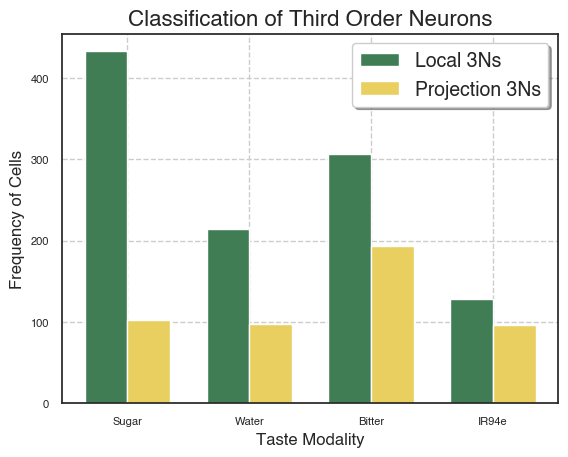

In [86]:
categories = ['Sugar','Water','Bitter','IR94e']
datasets = [sugar_3Ns, water_3Ns, bitter_3Ns, lowsalt_3Ns]

local_neurons = []
projection_neurons = []

for dataset in datasets:
    local_neurons.append(len(dataset.query("neuron_type == 'local'")))
    projection_neurons.append(len(dataset.query("neuron_type == 'projection'")))
    chi_3N_neurons = [local_neurons, projection_neurons]

x = range(len(categories))
bar_width = 0.35

plt.bar(x, local_neurons, width=bar_width,label = "Local 3Ns", color = '#407d55')
plt.bar([i+ bar_width for i in x], projection_neurons, width=bar_width, label = "Projection 3Ns", color = '#e8cf5f')

plt.xlabel('Taste Modality')
plt.ylabel('Frequency of Cells')
plt.title('Classification of Third Order Neurons')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend()
plt.show()

In [87]:
stat, p, dof, expected = chi2_contingency(chi_3N_neurons)

alpha = 0.05
print("p value is " + str(p) )
if p <= alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

p value is 1.0703107366395585e-13
Reject H0


### Comparing local vs projection third order synapses across modalities

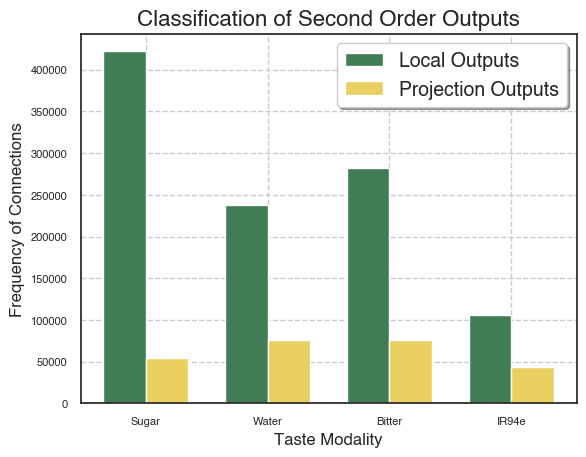

In [88]:
categories = ['Sugar','Water','Bitter','IR94e']
datasets = [sugar3N_outputs, water3N_outputs, bitter3N_outputs, lowsalt3N_outputs]

local_synapses = []
projection_synapses = []

for dataset in datasets:
    local_synapses.append(dataset.query("location_of_connection == 'local'")['syn_count'].sum())
    projection_synapses.append(dataset.query("location_of_connection == 'outside_SEZ'")['syn_count'].sum())
    chi_3N_synapses = [local_synapses, projection_synapses]
    
x = range(len(categories))

bar_width = 0.35

plt.bar(x, local_synapses, width=bar_width,label = "Local Outputs", color = '#407d55')
plt.bar([i+ bar_width for i in x], projection_synapses, width=bar_width, label = "Projection Outputs", color = '#e8cf5f')

plt.xlabel('Taste Modality')
plt.ylabel('Frequency of Connections')
plt.title('Classification of Second Order Outputs')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend()
plt.show()

In [89]:
stat, p, dof, expected = chi2_contingency(chi_3N_synapses)

alpha = 0.05
print("p value is " + str(p) )
if p <= alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

p value is 0.0
Reject H0


### NT distribution for local + projection 3N outputs across modalities

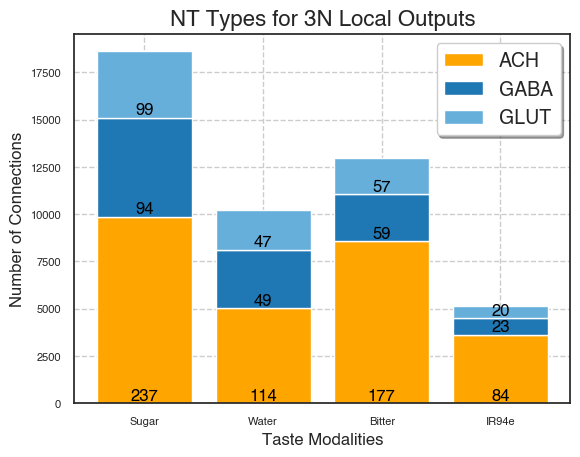

In [90]:
NTs = ['ACH','GABA','GLUT']
categories = ['Sugar','Water','Bitter','IR94e']

datasets = [sugar3N_outputs, water3N_outputs, bitter3N_outputs, lowsalt3N_outputs]
def count_NTs(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(len(dataset.query("location_of_connection == 'local' and nt_type == @NTs[0]")))
        ACH_connections = np.array(variable1)
        variable2.append(len(dataset.query("location_of_connection == 'local' and nt_type == @NTs[1]")))
        GABA_connections = np.array(variable2)
        variable3.append(len(dataset.query("location_of_connection == 'local' and nt_type == @NTs[2]")))
        GLUT_connections = np.array(variable3)
    return ACH_connections,GABA_connections,GLUT_connections

def count_neurons(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(dataset.query("location_of_connection == 'local' and nt_type == @NTs[0]")['pre_root_id'].nunique())
        ACH_neurons = np.array(variable1)
        variable2.append(dataset.query("location_of_connection == 'local' and nt_type == @NTs[1]")['pre_root_id'].nunique())
        GABA_neurons = np.array(variable2)
        variable3.append(dataset.query("location_of_connection == 'local' and nt_type == @NTs[2]")['pre_root_id'].nunique())
        GLUT_neurons = np.array(variable3)
    return ACH_neurons,GABA_neurons,GLUT_neurons

variables = count_NTs(datasets, categories)
neurons = count_neurons(datasets, categories)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(1,5)
bar_width = 0.8
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, variables[0], width=bar_width,color = 'orange')
ax2 = ax.bar(bar_l, variables[1], bottom = variables[0], width=bar_width,color = '#1f77b4')
ax3= ax.bar(bar_l, variables[2], bottom= variables[0]+variables[1], width=bar_width,color = '#67afdb')
ax.set_ylabel('Number of Connections')
ax.set_xlabel('Taste Modalities')
ax.legend(NTs)
ax.set_title('NT Types for 3N Local Outputs')
plt.xticks(tick_pos, categories)

for r1, r2, r3, n1, n2, n3 in zip(ax1, ax2, ax3, neurons[0], neurons[1], neurons[2]):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., 0, n1, ha="center", va="bottom", color="black", fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1, n2, ha="center", va="bottom", color="black",  fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 , n3, ha="center", va="bottom", color="black",  fontweight="bold")


plt.show()


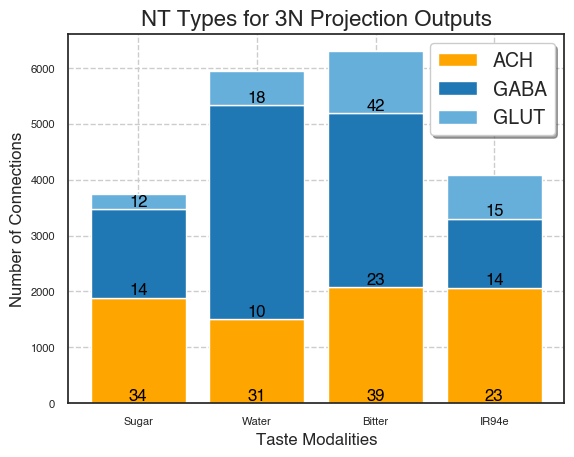

In [91]:
NTs = ['ACH','GABA','GLUT']
categories = ['Sugar','Water','Bitter','IR94e']

datasets = [sugar3N_outputs, water3N_outputs, bitter3N_outputs, lowsalt3N_outputs]
def count_NTs(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(len(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[0]")))
        ACH_connections = np.array(variable1)
        variable2.append(len(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[1]")))
        GABA_connections = np.array(variable2)
        variable3.append(len(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[2]")))
        GLUT_connections = np.array(variable3)
    return ACH_connections,GABA_connections,GLUT_connections

def count_neurons(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[0]")['pre_root_id'].nunique())
        ACH_neurons = np.array(variable1)
        variable2.append(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[1]")['pre_root_id'].nunique())
        GABA_neurons = np.array(variable2)
        variable3.append(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[2]")['pre_root_id'].nunique())
        GLUT_neurons = np.array(variable3)
    return ACH_neurons,GABA_neurons,GLUT_neurons

variables = count_NTs(datasets, categories)
neurons = count_neurons(datasets, categories)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(1,5)
bar_width = 0.8
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, variables[0], width=bar_width,color = 'orange')
ax2 = ax.bar(bar_l, variables[1], bottom = variables[0], width=bar_width,color = '#1f77b4')
ax3= ax.bar(bar_l, variables[2], bottom= variables[0]+variables[1], width=bar_width,color = '#67afdb')
ax.set_ylabel('Number of Connections')
ax.set_xlabel('Taste Modalities')
ax.legend(NTs)
ax.set_title('NT Types for 3N Projection Outputs')
plt.xticks(tick_pos, categories)

for r1, r2, r3, n1, n2, n3 in zip(ax1, ax2, ax3, neurons[0], neurons[1], neurons[2]):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., 0, n1, ha="center", va="bottom", color="black", fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1, n2, ha="center", va="bottom", color="black",  fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 , n3, ha="center", va="bottom", color="black",  fontweight="bold")


plt.show()


### Mapping out ipsilateral vs contralateal 3N outputs across modalities

In [92]:
sugar3N_outputs['hemisphere'] = sugar3N_outputs['neuropil'].apply(bilateral)
water3N_outputs['hemisphere'] = water3N_outputs['neuropil'].apply(bilateral)
bitter3N_outputs['hemisphere'] = bitter3N_outputs['neuropil'].apply(bilateral)
lowsalt3N_outputs['hemisphere'] = lowsalt3N_outputs['neuropil'].apply(bilateral)

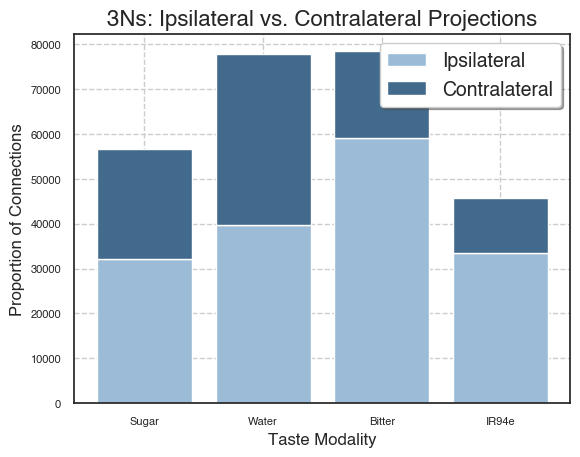

In [93]:
third_order_outputs = [sugar3N_outputs, water3N_outputs, bitter3N_outputs, lowsalt3N_outputs]

ipsilateral = []
contralateral = []

for entry in third_order_outputs:
    ipsilateral.append(entry.query("hemisphere == 'ipsilateral'")['syn_count'].sum())
    contralateral.append(entry.query("hemisphere == 'contralateral'")['syn_count'].sum())

categories = ['Sugar', 'Water', 'Bitter', 'IR94e']
brain_hemisphere = ['Ipsilateral', 'Contralateral']

plt.bar(categories, ipsilateral, color = '#9cbbd6')
plt.bar(categories, contralateral, bottom = ipsilateral, color = '#426a8c')
plt.title('3Ns: Ipsilateral vs. Contralateral Projections')
plt.ylabel('Proportion of Connections')
plt.xlabel('Taste Modality')
plt.legend(brain_hemisphere)
plt.show()


### Consolidating bilateral brain regions for third order outputs

In [94]:
sugar3N_outputs['neuropil_remap'] = sugar3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
water3N_outputs['neuropil_remap'] = water3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
bitter3N_outputs['neuropil_remap'] = bitter3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
lowsalt3N_outputs['neuropil_remap'] = lowsalt3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))

### Bar graph of brain regions that each modality is projecting to

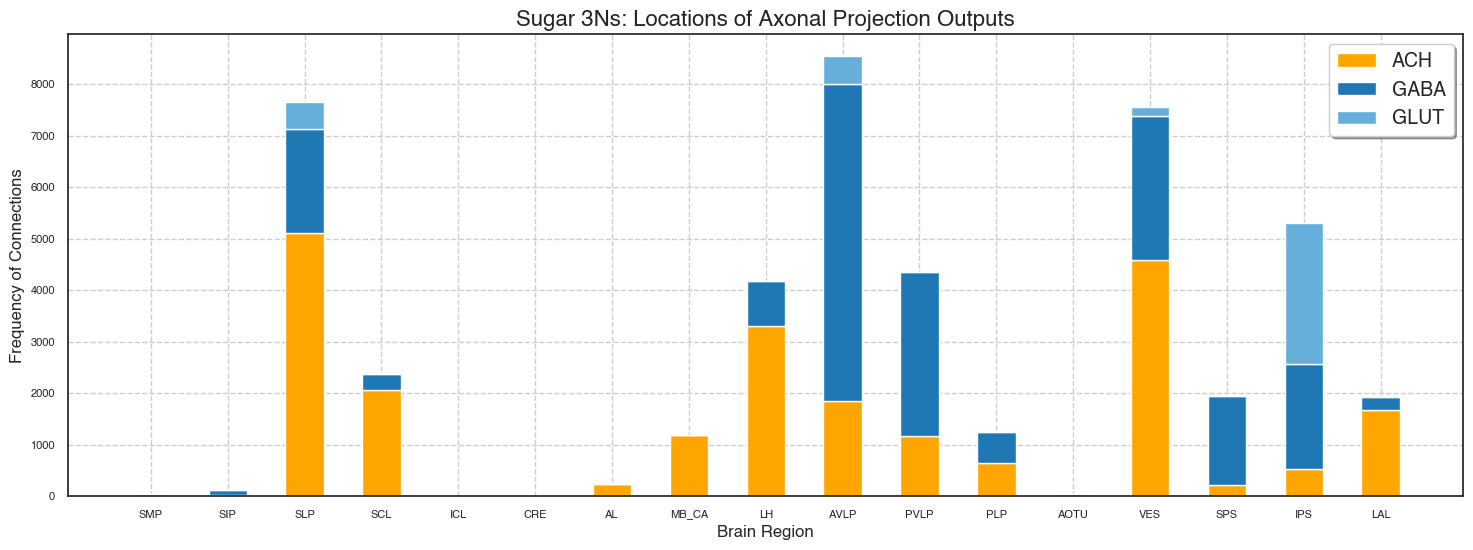

In [95]:
categories = ['SMP','SIP','SLP', \
              'SCL','ICL','CRE',\
              'AL',\
                'MB_CA',\
                    'LH',\
                        'AVLP','PVLP','PLP','AOTU',\
                            'VES', 'SPS','IPS',\
                            'LAL']

datasets = []
for category in categories:
    counts = pd.DataFrame(sugar3N_outputs[sugar3N_outputs['neuropil_remap'] == category])
    datasets.append(counts)

NTs = ['ACH','GABA','GLUT']

def count_NTs(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(dataset.query("nt_type == @NTs[0]")['syn_count'].sum())
        ACH_connections = np.array(variable1)
        variable2.append(dataset.query("nt_type == @NTs[1]")['syn_count'].sum())
        GABA_connections = np.array(variable2)
        variable3.append(dataset.query("nt_type == @NTs[2]")['syn_count'].sum())
        GLUT_connections = np.array(variable3)
    return ACH_connections,GABA_connections,GLUT_connections

variables = count_NTs(datasets, categories)

plt.figure(figsize=(18, 6))
plt.bar(categories, variables[0], color= 'orange', width = 0.5)
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5)
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5)

plt.xlabel('Brain Region')
plt.ylabel('Frequency of Connections')
plt.title('Sugar 3Ns: Locations of Axonal Projection Outputs')
plt.legend(NTs)
plt.show()

# sum(sum(variables))/sugar3N_outputs.query("nt_type.isin(['ACH','GABA','GLUT']) & location_of_connection == 'outside_SEZ'")['syn_count'].sum()
# captures 96.2% of water outputs


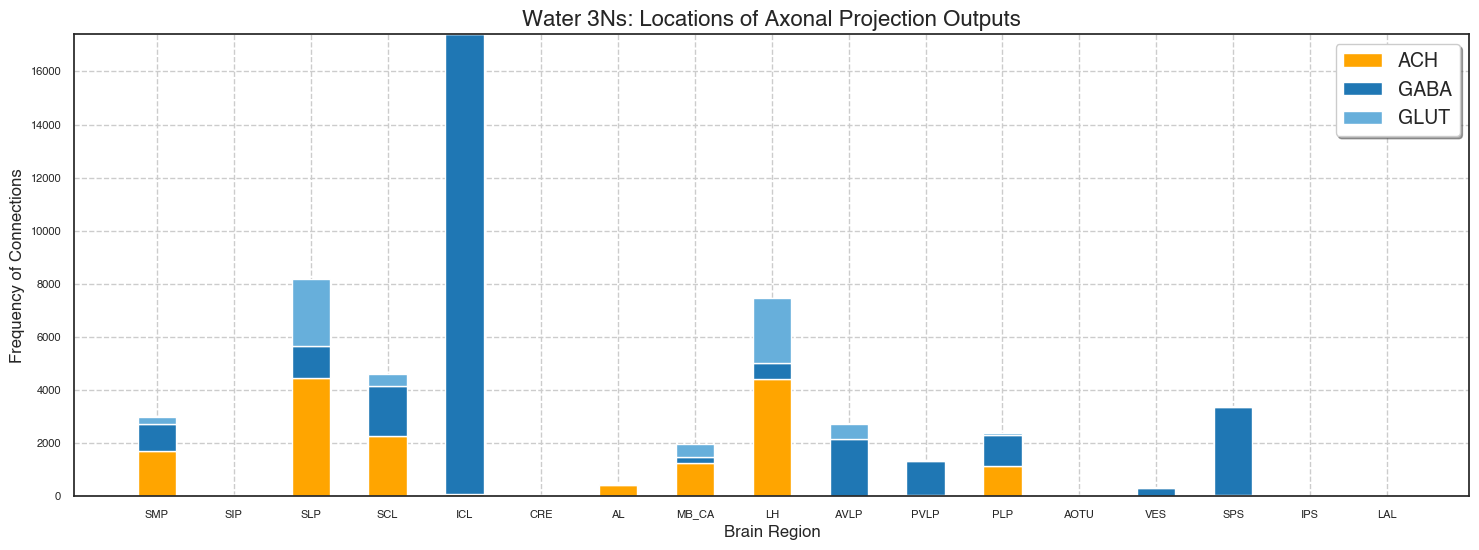

In [96]:
categories = ['SMP','SIP','SLP', \
              'SCL','ICL','CRE',\
              'AL',\
                'MB_CA',\
                    'LH',\
                        'AVLP','PVLP','PLP','AOTU',\
                            'VES', 'SPS','IPS',\
                            'LAL']

#captures 90.6% of water outputs

datasets = []
for category in categories:
    counts = pd.DataFrame(water3N_outputs[water3N_outputs['neuropil_remap'] == category])
    datasets.append(counts)

NTs = ['ACH','GABA','GLUT']

def count_NTs(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(dataset.query("nt_type == @NTs[0]")['syn_count'].sum())
        ACH_connections = np.array(variable1)
        variable2.append(dataset.query("nt_type == @NTs[1]")['syn_count'].sum())
        GABA_connections = np.array(variable2)
        variable3.append(dataset.query("nt_type == @NTs[2]")['syn_count'].sum())
        GLUT_connections = np.array(variable3)
    return ACH_connections,GABA_connections,GLUT_connections

variables = count_NTs(datasets, categories)

plt.figure(figsize=(18, 6))
plt.bar(categories, variables[0], color= 'orange', width = 0.5)
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5)
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5)

plt.xlabel('Brain Region')
plt.ylabel('Frequency of Connections')
plt.title('Water 3Ns: Locations of Axonal Projection Outputs')
plt.legend(NTs)
plt.show()

# sum(sum(variables))/water3N_outputs.query("nt_type.isin(['ACH','GABA','GLUT']) & location_of_connection == 'outside_SEZ'")['syn_count'].sum()
# captures 90.6% of water outputs

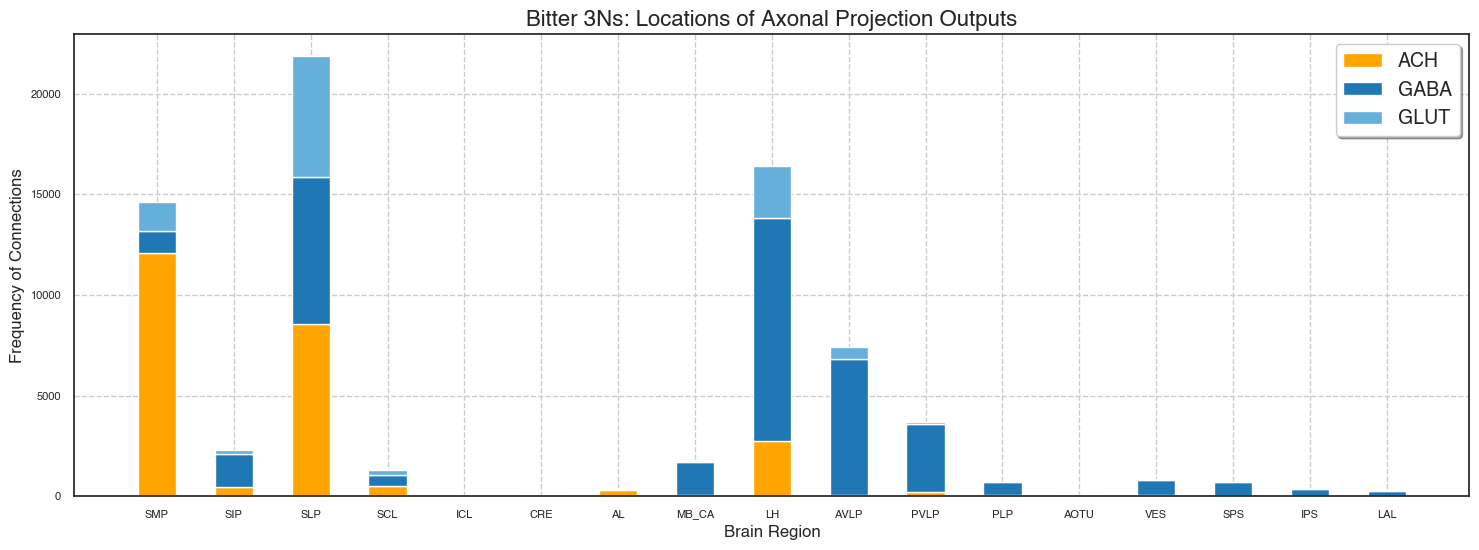

In [97]:
categories = ['SMP','SIP','SLP', \
              'SCL','ICL','CRE',\
              'AL',\
                'MB_CA',\
                    'LH',\
                        'AVLP','PVLP','PLP','AOTU',\
                            'VES', 'SPS','IPS',\
                            'LAL' ]

datasets = []
for category in categories:
    counts = pd.DataFrame(bitter3N_outputs[bitter3N_outputs['neuropil_remap'] == category])
    datasets.append(counts)

NTs = ['ACH','GABA','GLUT']

def count_NTs(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(dataset.query("nt_type == @NTs[0]")['syn_count'].sum())
        ACH_connections = np.array(variable1)
        variable2.append(dataset.query("nt_type == @NTs[1]")['syn_count'].sum())
        GABA_connections = np.array(variable2)
        variable3.append(dataset.query("nt_type == @NTs[2]")['syn_count'].sum())
        GLUT_connections = np.array(variable3)
    return ACH_connections,GABA_connections,GLUT_connections

variables = count_NTs(datasets, categories)

plt.figure(figsize=(18, 6))
plt.bar(categories, variables[0], color= 'orange', width = 0.5)
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5)
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5)

plt.xlabel('Brain Region')
plt.ylabel('Frequency of Connections')
plt.title('Bitter 3Ns: Locations of Axonal Projection Outputs')
plt.legend(NTs)
plt.show()

# sum(sum(variables))/bitter3N_outputs.query("nt_type.isin(['ACH','GABA','GLUT']) & location_of_connection == 'outside_SEZ'")['syn_count'].sum()
# captures 94.2% of bitter outputs

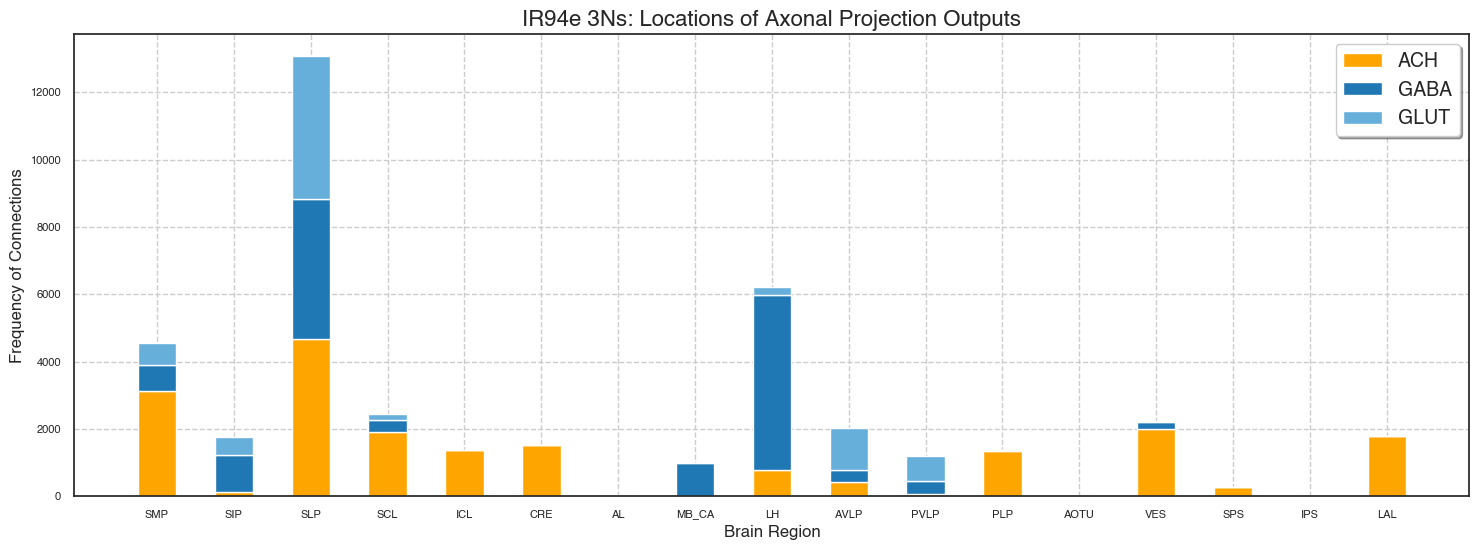

In [98]:
categories = ['SMP','SIP','SLP', \
              'SCL','ICL','CRE',\
              'AL',\
                'MB_CA',\
                    'LH',\
                        'AVLP','PVLP','PLP','AOTU',\
                            'VES', 'SPS','IPS',\
                            'LAL']

datasets = []
for category in categories:
    counts = pd.DataFrame(lowsalt3N_outputs[lowsalt3N_outputs['neuropil_remap'] == category])
    datasets.append(counts)

NTs = ['ACH','GABA','GLUT']

def count_NTs(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(dataset.query("nt_type == @NTs[0]")['syn_count'].sum())
        ACH_connections = np.array(variable1)
        variable2.append(dataset.query("nt_type == @NTs[1]")['syn_count'].sum())
        GABA_connections = np.array(variable2)
        variable3.append(dataset.query("nt_type == @NTs[2]")['syn_count'].sum())
        GLUT_connections = np.array(variable3)
    return ACH_connections,GABA_connections,GLUT_connections

variables = count_NTs(datasets, categories)

plt.figure(figsize=(18, 6))
plt.bar(categories, variables[0], color= 'orange', width = 0.5)
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5)
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5)

plt.xlabel('Brain Region')
plt.ylabel('Frequency of Connections')
plt.title('IR94e 3Ns: Locations of Axonal Projection Outputs')
plt.legend(NTs)
plt.show()

# sum(sum(variables))/lowsalt3N_outputs.query("nt_type.isin(['ACH','GABA','GLUT']) & location_of_connection == 'outside_SEZ'")['syn_count'].sum()
# captures 97.3% of IR94e outputs

### Looking at difference in excitatory vs inhibitory synapses onto individual neurons
- excluding third order neurons that only receive input from one second order

In [99]:

def net_excitation(taste_3Ns, taste_third_order_connectivity, taste):
    data = taste_3Ns[taste_3Ns['upstream_' + taste + '_2Ns'] != 1]['root_id']
    taste_third_order_connectivity = taste_third_order_connectivity[taste_third_order_connectivity['post_root_id'].isin(data)]
    excitatory = taste_third_order_connectivity.query("nt_type == 'ACH'").groupby("post_root_id")["syn_count"].sum().reset_index() 
    inhibitory = taste_third_order_connectivity.query("nt_type == 'GABA' | nt_type == 'GLUT'").groupby("post_root_id")["syn_count"].sum().reset_index() 
    net_excitation = pd.merge(excitatory, inhibitory, on='post_root_id', how='outer').fillna(0)
    net_excitation.rename(columns={'post_root_id': 'root_id','syn_count_x': 'excitatory_syn_count','syn_count_y':'inhibitory_syn_count'}, inplace=True)
    net_excitation['net_excitation'] = net_excitation['excitatory_syn_count'] - net_excitation['inhibitory_syn_count']
    return net_excitation

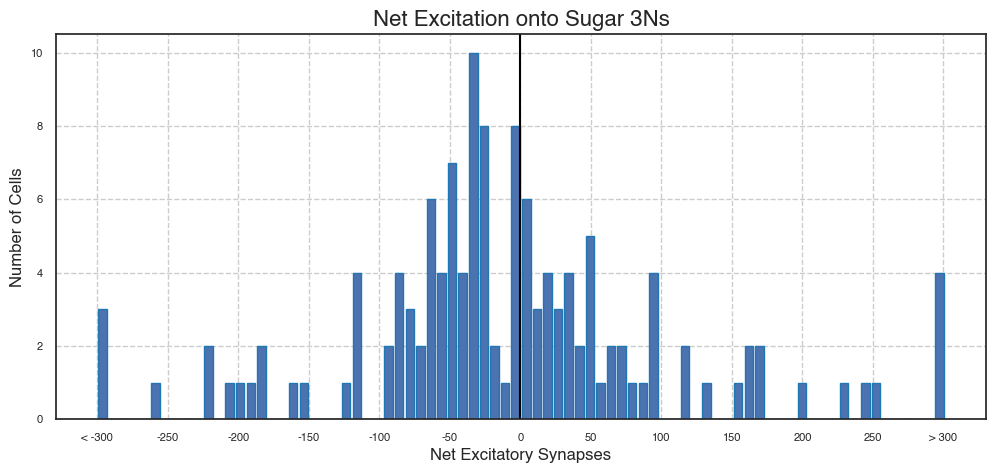

In [100]:
sugar_net_excitation = net_excitation(sugar_3Ns, sugar_third_order_connectivity, 'sugar')
num_bins = 80
bins = np.linspace(-300, 301, num_bins + 1)
data = np.clip(sugar_net_excitation['net_excitation'], bins[0], bins[-1])
sugar_frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

plt.figure(figsize=(12, 5))
plt.bar(bin_labels, sugar_frequencies, width=6, align='center', edgecolor='tab:blue')
plt.axvline(0, color='black')
bin_labels = np.arange(-300,301, 50)
xlabels = np.array(bin_labels, dtype= str)
xlabels[-1] = '> 300'
xlabels[0] = '< -300'
plt.xticks(ticks = 50 * np.arange(len(xlabels)) - 300, labels = xlabels)
plt.xlabel('Net Excitatory Synapses')
plt.ylabel('Number of Cells')
plt.title('Net Excitation onto Sugar 3Ns')
plt.show()

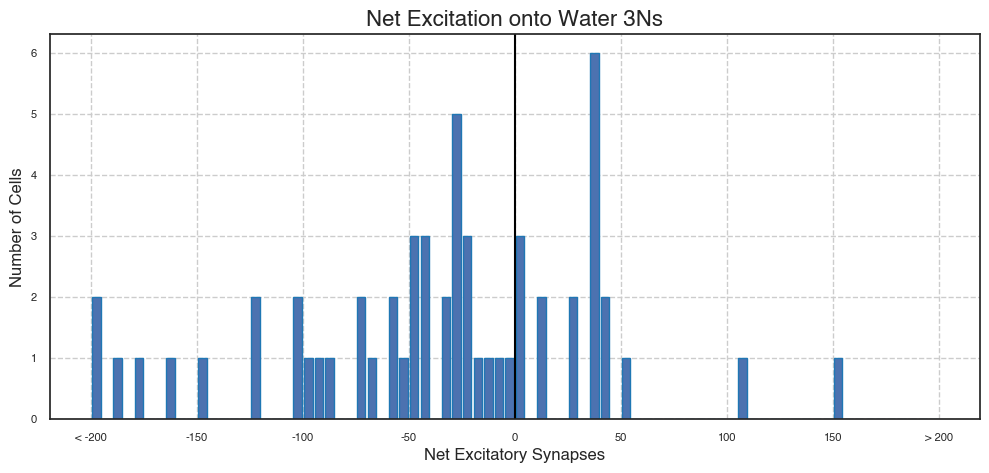

In [101]:
water_net_excitation = net_excitation(water_3Ns, water_third_order_connectivity, 'water')
num_bins = 80
bins = np.linspace(-200, 200, num_bins + 1)
data = np.clip(water_net_excitation['net_excitation'], bins[0], bins[-1])
water_frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

plt.figure(figsize=(12, 5))
plt.bar(bin_labels, water_frequencies, width=4, align='center', edgecolor='tab:blue')
plt.axvline(0, color='black')
bin_labels = np.arange(-200,201, 50)
xlabels = np.array(bin_labels, dtype= str)
xlabels[-1] = '> 200'
xlabels[0] = '< -200'
plt.xticks(ticks = 50 * np.arange(len(xlabels)) - 200, labels = xlabels)
plt.xlabel('Net Excitatory Synapses')
plt.ylabel('Number of Cells')
plt.title('Net Excitation onto Water 3Ns')
plt.show()


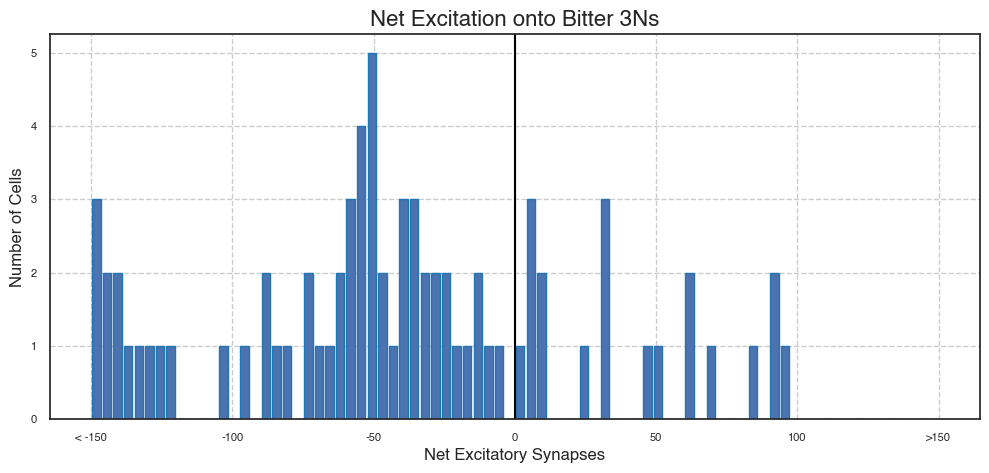

In [102]:
bitter_net_excitation = net_excitation(bitter_3Ns, bitter_third_order_connectivity, 'bitter')
num_bins = 80
bins = np.linspace(-150, 150, num_bins + 1)
data = np.clip(bitter_net_excitation['net_excitation'], bins[0], bins[-1])
bitter_frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

plt.figure(figsize=(12, 5))
plt.bar(bin_labels, bitter_frequencies, width=3, align='center', edgecolor='tab:blue')
plt.axvline(0, color='black')
bin_labels = np.arange(-150,151, 50)
xlabels = np.array(bin_labels, dtype= str)
xlabels[-1] = '>150'
xlabels[0] = '< -150'
plt.xticks(ticks = 50 * np.arange(len(xlabels)) - 150, labels = xlabels)
plt.xlabel('Net Excitatory Synapses')
plt.ylabel('Number of Cells')
plt.title('Net Excitation onto Bitter 3Ns')
plt.show()

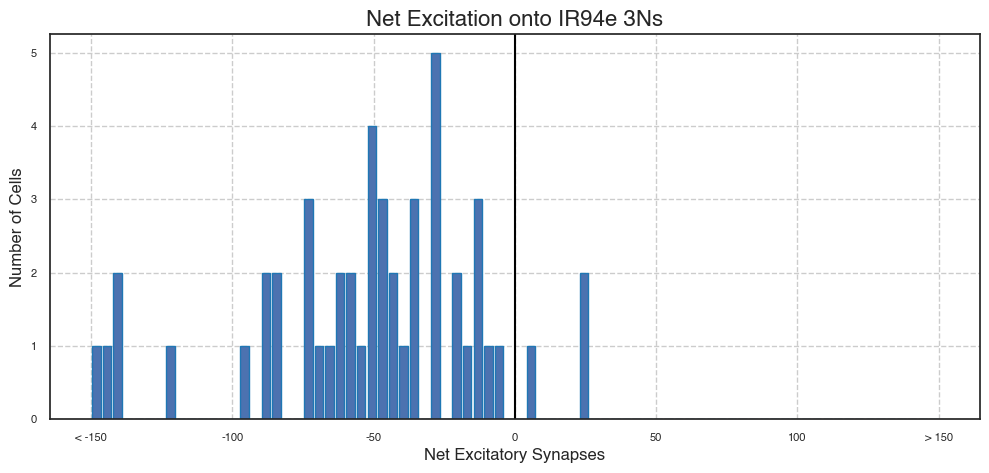

In [103]:
lowsalt_net_excitation = net_excitation(lowsalt_3Ns, lowsalt_third_order_connectivity, 'lowsalt')
num_bins = 80
bins = np.linspace(-150, 150, num_bins + 1)
data = np.clip(lowsalt_net_excitation['net_excitation'], bins[0], bins[-1])
lowsalt_frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

plt.figure(figsize=(12, 5))
plt.bar(bin_labels, lowsalt_frequencies, width=3, align='center', edgecolor='tab:blue')
plt.axvline(0, color='black')
bin_labels = np.arange(-150,151, 50)
xlabels = np.array(bin_labels, dtype= str)
xlabels[-1] = '> 150'
xlabels[0] = '< -150'
plt.xticks(ticks = 50 * np.arange(len(xlabels)) - 150, labels = xlabels)
plt.xlabel('Net Excitatory Synapses')
plt.ylabel('Number of Cells')
plt.title('Net Excitation onto IR94e 3Ns')
plt.show()